# **Práctica: Redes Recurrentes**

* **Asignatura:** Aprendizaje Profundo
* **Máster:** Inteligencia Computacional e Internet de las Cosas
* **Estudiante:** Mabrouka Salmi
* **Fecha:** 01/04/2024

📋 **Contenido:**
1.  Data Importing

2.  LSTM data preparation

3.  Training and Evaluating LSTM
    * Trial 1
    * Trial 2
    * Trial 3
    * Trial 4
4.  Conclusion

## **1. Data Importing**

In [1]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/AP/produccion-energia.csv")
print(df.head(), '\n')

# set the `DATE` as the data index
df.DATE = pd.to_datetime(df.DATE)
df.set_index("DATE", inplace = True)

# Change the name of the data columns -> `Production`
df.rename(columns={"IPG2211A2N":"Production"}, inplace=True) # changed the column name of the series
print(df.head())

# Plot the data


         DATE  IPG2211A2N
0  1939-01-01      3.3842
1  1939-02-01      3.4100
2  1939-03-01      3.4875
3  1939-04-01      3.5133
4  1939-05-01      3.5133 

            Production
DATE                  
1939-01-01      3.3842
1939-02-01      3.4100
1939-03-01      3.4875
1939-04-01      3.5133
1939-05-01      3.5133


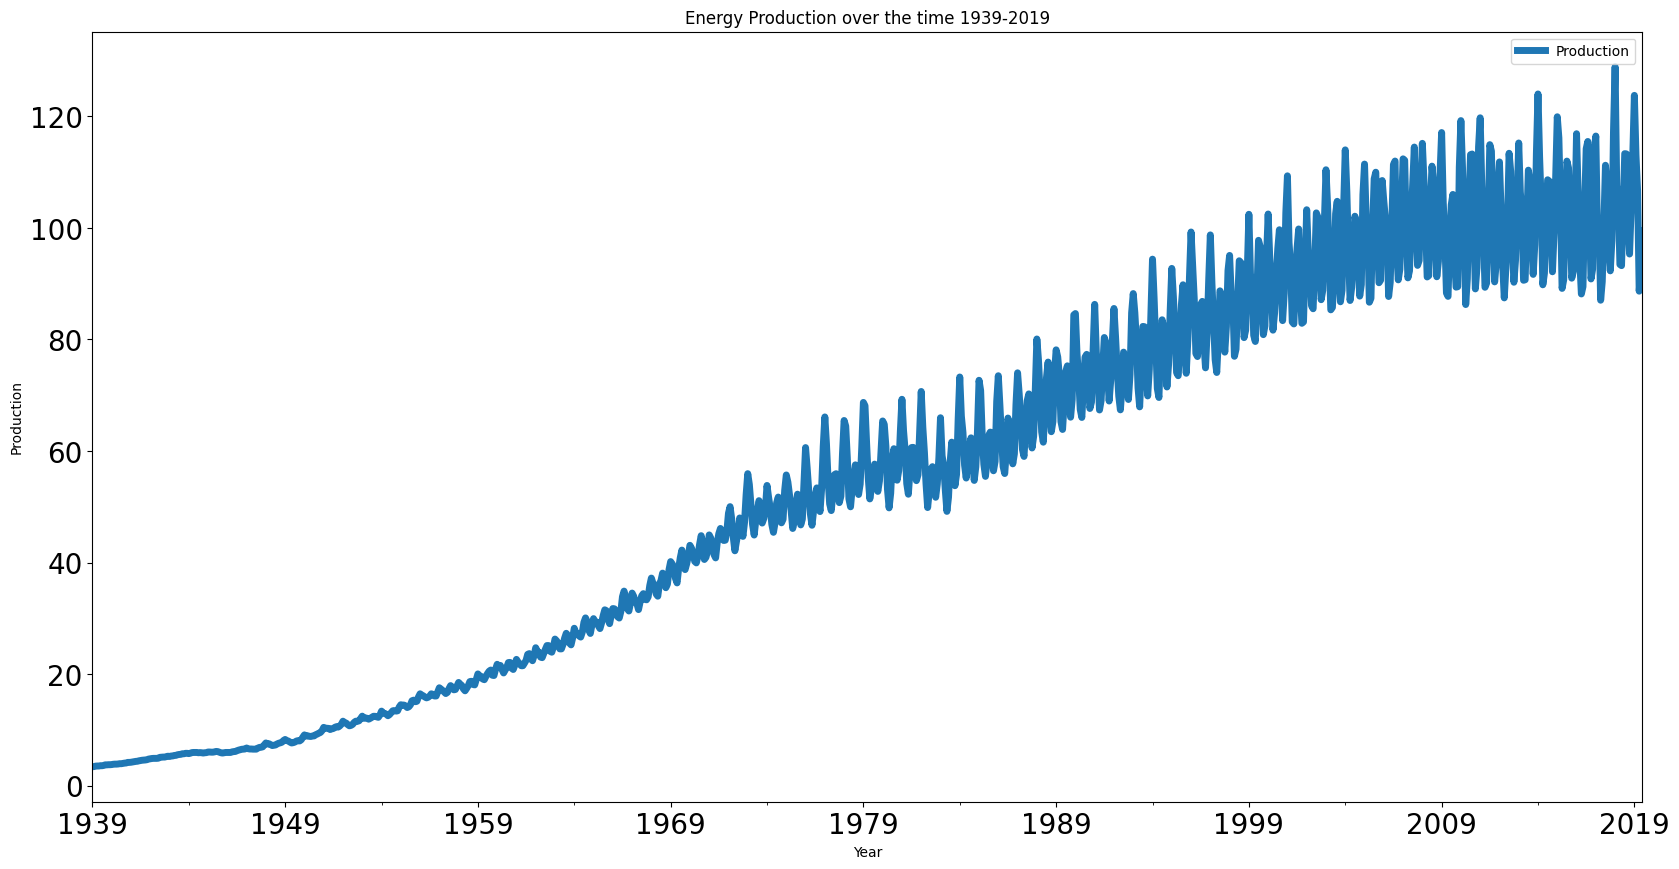

In [3]:
# PLot the data
df.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title("Energy Production over the time 1939-2019")
plt.ylabel('Production')
plt.xlabel('Year')
plt.show()

## **2. LSTM data preparation**

* Scaling the time series data to be in the range [0,1] using `MinMaxScaler`

In [4]:
production = df['Production']
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(production.values.reshape(-1,1))

# scale train and test data to [0, 1]
def scale(train, test):
 # fit scaler
 scaler = MinMaxScaler(feature_range=(0, 1))
 scaler = scaler.fit(train)
 # transform train
 train = train.reshape(train.shape[0], train.shape[1])
 train_scaled = scaler.transform(train)
 # transform test
 test = test.reshape(test.shape[0], test.shape[1])
 test_scaled = scaler.transform(test)
 return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = np.concatenate((X, np.array([value])))
    new_row = new_row.reshape(1, -1)
    inverted = scaler.inverse_transform(new_row)
    return inverted[0, -1]

* Train-test Split using the ratio 70% - 30%

In [5]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

* Transform time series to supervised learning using `one-to-one` strategy, where each input (observation from the last time step (`t-1`)) is directly mapped to a single output (the observation at the current time step (t))

* Prepare the train and test sets to be in the shape expected by the LSTM model `[samples, time steps, features]`

In [6]:
# Convertir un array en un conjunto de datos
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    dataX = numpy.array(dataX)
    dataY = numpy.array(dataY)
    dataX = dataX.reshape(dataX.shape[0], 1, dataX.shape[1])
    return dataX, dataY

In [7]:
look_back = 1
# Preparar el conjunto de train
trainX, trainY = create_dataset(train, look_back)

# Preparar el conjunto de test
testX, testY = create_dataset(test, look_back)

# Check the shape of the train and test
print('The shape of the train set : ', trainX.shape, '\n')
print('The shape of the test set : ', testX.shape, '\n')

The shape of the train set :  (674, 1, 1) 

The shape of the test set :  (288, 1, 1) 



## **3. Training and Evaluation of LSTM**

### **Trial 1**

* LSTM design

The network has a visible layer with 1 input, a hidden layer with 10 LSTM blocks or neurons, and an output layer that makes a single value prediction.

In [ ]:
# Tamaño de batch
batch_size=1 # cada patron optimizar los pesos

# Crear un modelo secuencial
model = Sequential()

# Crear una capa LSTM
model.add(LSTM(10, batch_input_shape=(batch_size, look_back, 1), stateful=True)) # stateful:  recordar del h_t

# Crear una capa densa
model.add(Dense(1))

* Compile and train the model on the train set

In [ ]:
# Compilar el modelo
model.compile(optimizer="adam", loss='mean_squared_error')

# Entrenamiento habitual (no resetearía el estado)
# model.fit(trainX, trainY, epochs=30, batch_size=1)

# Entrenar el modelo con reseteo explícito
for i in range(100):
  print('Época %d'%(i))
  model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
  model.reset_states()

Época 0
674/674 - 4s - loss: 0.0010 - 4s/epoch - 6ms/step
Época 1
674/674 - 1s - loss: 0.0015 - 1s/epoch - 2ms/step
Época 2
674/674 - 1s - loss: 0.0011 - 1s/epoch - 2ms/step
Época 3
674/674 - 2s - loss: 9.3670e-04 - 2s/epoch - 3ms/step
Época 4
674/674 - 2s - loss: 8.6005e-04 - 2s/epoch - 3ms/step
Época 5
674/674 - 3s - loss: 8.2448e-04 - 3s/epoch - 4ms/step
Época 6
674/674 - 2s - loss: 7.9187e-04 - 2s/epoch - 3ms/step
Época 7
674/674 - 2s - loss: 9.0228e-04 - 2s/epoch - 3ms/step
Época 8
674/674 - 1s - loss: 9.1764e-04 - 1s/epoch - 2ms/step
Época 9
674/674 - 3s - loss: 9.9270e-04 - 3s/epoch - 4ms/step
Época 10
674/674 - 3s - loss: 9.3689e-04 - 3s/epoch - 4ms/step
Época 11
674/674 - 2s - loss: 8.7270e-04 - 2s/epoch - 3ms/step
Época 12
674/674 - 2s - loss: 8.1489e-04 - 2s/epoch - 3ms/step
Época 13
674/674 - 2s - loss: 8.2769e-04 - 2s/epoch - 2ms/step
Época 14
674/674 - 2s - loss: 6.8550e-04 - 2s/epoch - 2ms/step
Época 15
674/674 - 2s - loss: 0.0015 - 2s/epoch - 3ms/step
Época 16
674/674 -

* Get predictions using the trained LSTM model

In [ ]:
# Realizar las predicciones
trainPredict = model.predict(trainX,batch_size=batch_size)
testPredict = model.predict(testX,batch_size=batch_size)
# Deshacer la normalización
trainPredict = scaler.inverse_transform(trainPredict)
trainYOriginal = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testYOriginal = scaler.inverse_transform([testY])
# Calcular los error
trainScore = math.sqrt(mean_squared_error(trainYOriginal[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYOriginal[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

288/288 [==============================] - 1s 2ms/step
Train Score: 35.97 RMSE
Test Score: 69.02 RMSE


✍ The remarkable difference between the `rmse` score on the train and test refers to a possible overfitting to the train data, besides the `rmse` score overall are high and further model modifications/preprocessing could improve the results.

### **Trial 2**

The LSTM in this has a hidden layer with 5 LSTM neurons, an output layer with one value predicition (the production), and 200 epochs.

In [15]:
# Tamaño de batch
batch_size=1 # cada patron optimizar los pesos

# Crear un modelo secuencial
model = Sequential()

# Crear una capa LSTM
model.add(LSTM(5, batch_input_shape=(batch_size, look_back, 1), stateful=True)) # stateful:  recordar del h_t

# Crear una capa densa
model.add(Dense(1))

In [16]:
# Compilar el modelo
model.compile(optimizer="adam", loss='mean_squared_error')

# Entrenamiento habitual (no resetearía el estado)
# model.fit(trainX, trainY, epochs=30, batch_size=1)

# Entrenar el modelo con reseteo explícito
for i in range(200):
  print('Época %d'%(i))
  model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
  model.reset_states()

Época 0
674/674 - 2s - loss: 9.7599e-04 - 2s/epoch - 3ms/step
Época 1
674/674 - 1s - loss: 0.0023 - 787ms/epoch - 1ms/step
Época 2
674/674 - 1s - loss: 0.0017 - 767ms/epoch - 1ms/step
Época 3
674/674 - 1s - loss: 0.0012 - 802ms/epoch - 1ms/step
Época 4
674/674 - 1s - loss: 0.0010 - 801ms/epoch - 1ms/step
Época 5
674/674 - 1s - loss: 9.4033e-04 - 779ms/epoch - 1ms/step
Época 6
674/674 - 1s - loss: 9.0070e-04 - 799ms/epoch - 1ms/step
Época 7
674/674 - 1s - loss: 8.7630e-04 - 1s/epoch - 2ms/step
Época 8
674/674 - 1s - loss: 8.5607e-04 - 969ms/epoch - 1ms/step
Época 9
674/674 - 1s - loss: 8.3614e-04 - 786ms/epoch - 1ms/step
Época 10
674/674 - 1s - loss: 8.1473e-04 - 794ms/epoch - 1ms/step
Época 11
674/674 - 1s - loss: 7.9071e-04 - 782ms/epoch - 1ms/step
Época 12
674/674 - 1s - loss: 7.6320e-04 - 819ms/epoch - 1ms/step
Época 13
674/674 - 1s - loss: 7.3156e-04 - 796ms/epoch - 1ms/step
Época 14
674/674 - 1s - loss: 6.9569e-04 - 787ms/epoch - 1ms/step
Época 15
674/674 - 1s - loss: 6.5636e-04 -

In [17]:
# Realizar las predicciones
trainPredict = model.predict(trainX,batch_size=batch_size)
testPredict = model.predict(testX,batch_size=batch_size)
# Deshacer la normalización
trainPredict = scaler.inverse_transform(trainPredict)
trainYOriginal = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testYOriginal = scaler.inverse_transform([testY])
# Calcular los error
trainScore = math.sqrt(mean_squared_error(trainYOriginal[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYOriginal[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

288/288 [==============================] - 0s 976us/step
Train Score: 3.55 RMSE
Test Score: 9.79 RMSE


✍ The `rmse` scores on the train and test sets have been quite improved with the parameters setting in trial 2. Decreasing the number of LSTM neurons from 10 to 5 and increasing the number of epochs to 200 yielded to significant prediction results.

* Plotting the predicted values along with the actual values

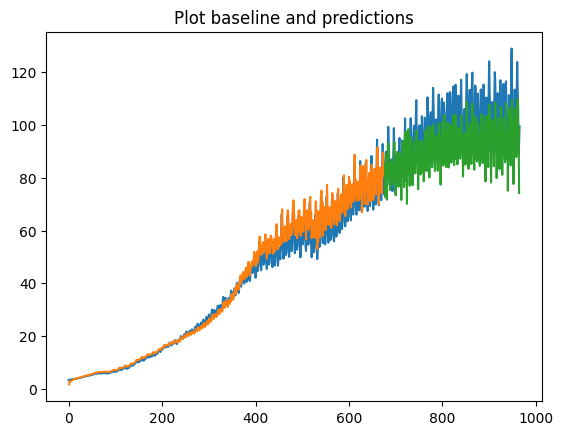

In [18]:
# Hacer un shift de las predicciones de entrenamiento para el plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# Hacer un shift de las predicciones de test para el plot
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Representar las predicciones
plt.title("Plot baseline and predictions")
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()



### **Trial 3**

The LSTM  model in trial 3 is designed with 4 LSTM neurons in the hidden layer and 300 epochs

In [11]:
# Tamaño de batch
batch_size=1 # cada patron optimizar los pesos

# Crear un modelo secuencial
model = Sequential()

# Crear una capa LSTM
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True)) # stateful:  recordar del h_t

# Crear una capa densa
model.add(Dense(1))

In [12]:
# Compilar el modelo
model.compile(optimizer="adam", loss='mean_squared_error')

# Entrenamiento habitual (no resetearía el estado)
# model.fit(trainX, trainY, epochs=30, batch_size=1)

# Entrenar el modelo con reseteo explícito
for i in range(300):
  print('Época %d'%(i))
  model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
  model.reset_states()

Época 0
674/674 - 2s - loss: 8.6330e-04 - 2s/epoch - 3ms/step
Época 1
674/674 - 1s - loss: 0.0020 - 723ms/epoch - 1ms/step
Época 2
674/674 - 1s - loss: 0.0013 - 723ms/epoch - 1ms/step
Época 3
674/674 - 1s - loss: 0.0011 - 724ms/epoch - 1ms/step
Época 4
674/674 - 1s - loss: 9.4047e-04 - 994ms/epoch - 1ms/step
Época 5
674/674 - 1s - loss: 8.8447e-04 - 740ms/epoch - 1ms/step
Época 6
674/674 - 1s - loss: 8.5885e-04 - 725ms/epoch - 1ms/step
Época 7
674/674 - 1s - loss: 8.4421e-04 - 734ms/epoch - 1ms/step
Época 8
674/674 - 1s - loss: 8.3342e-04 - 726ms/epoch - 1ms/step
Época 9
674/674 - 1s - loss: 8.2359e-04 - 717ms/epoch - 1ms/step
Época 10
674/674 - 1s - loss: 8.1321e-04 - 725ms/epoch - 1ms/step
Época 11
674/674 - 1s - loss: 8.0106e-04 - 741ms/epoch - 1ms/step
Época 12
674/674 - 1s - loss: 7.8572e-04 - 857ms/epoch - 1ms/step
Época 13
674/674 - 1s - loss: 7.6546e-04 - 871ms/epoch - 1ms/step
Época 14
674/674 - 1s - loss: 7.3876e-04 - 1s/epoch - 2ms/step
Época 15
674/674 - 1s - loss: 7.0540e-

In [13]:
# Realizar las predicciones
trainPredict = model.predict(trainX,batch_size=batch_size)
testPredict = model.predict(testX,batch_size=batch_size)
# Deshacer la normalización
trainPredict = scaler.inverse_transform(trainPredict)
trainYOriginal = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testYOriginal = scaler.inverse_transform([testY])
# Calcular los error
trainScore = math.sqrt(mean_squared_error(trainYOriginal[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYOriginal[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

288/288 [==============================] - 0s 996us/step
Train Score: 3.30 RMSE
Test Score: 8.32 RMSE


* Plotting the predictions

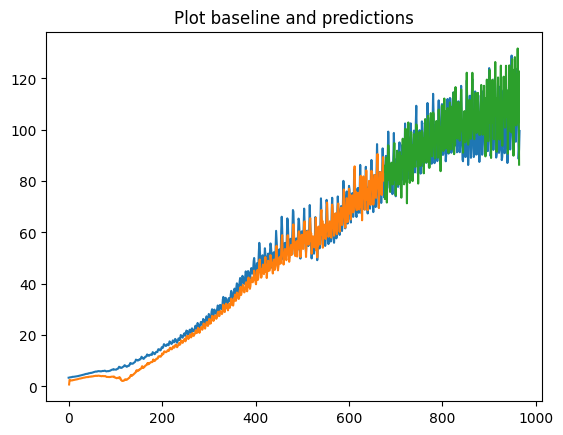

In [14]:
# Hacer un shift de las predicciones de entrenamiento para el plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# Hacer un shift de las predicciones de test para el plot
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Representar las predicciones
plt.title("Plot baseline and predictions")
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()



✍ In trial 3, we further decreased the number of LSTM blocks to 4 and increased the number of epochs, we see that the difference in the `rmse` score difference between the train and the test is further minimized, yet the `rmse` on both subsets are better than that of the other trials.

### **Trial 4**

In this case, we transform the time series to stationary. We know from the previous excercice that the data is not stationary, a common way to handle it is the differencign with one lag. Although, we know `a-priori`, the differencing with 12 lags removed not only the trend but also the seasonality and transformed the time series to stationary according the Augmented Dickey-Fuller test, we tend to use a common practice which is the differencig with one lag.

* Defined Functions for preprocessing, training, and forecasting

In [ ]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
 df = DataFrame(data)
 columns = [df.shift(i) for i in range(1, lag+1)]
 columns.append(df)
 df = concat(columns, axis=1)
 df.fillna(0, inplace=True)
 return df
from pandas import Series
# create a differenced series
def difference(dataset, interval=12):
 diff = list()
 for i in range(interval, len(dataset)):
  value = dataset[i] - dataset[i - interval]
  diff.append(value)
 return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=12):
 return yhat + history[-interval]

In [ ]:
# scale train and test data to [-1, 1]
def scale(train, test):
 # fit scaler
 scaler = MinMaxScaler(feature_range=(-1, 1))
 scaler = scaler.fit(train)
 # transform train
 train = train.reshape(train.shape[0], train.shape[1])
 train_scaled = scaler.transform(train)
 # transform test
 test = test.reshape(test.shape[0], test.shape[1])
 test_scaled = scaler.transform(test)
 return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
 new_row = [x for x in X] + [value]
 array = numpy.array(new_row)
 array = array.reshape(1, len(array))
 inverted = scaler.inverse_transform(array)
 return inverted[0, -1]

In [ ]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
 X, y = train[:, 0:-1], train[:, -1]
 X = X.reshape(X.shape[0], 1, X.shape[1])
 model = Sequential()
 model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
 model.add(Dense(1))
 model.compile(loss='mean_squared_error', optimizer='adam')
 for i in range(nb_epoch):
  print('Época %d'%(i))
  model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
  model.reset_states()
 return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
 X = X.reshape(1, 1, len(X))
 yhat = model.predict(X, batch_size=batch_size)
 return yhat[0,0]

* LSTM Data Preparation

In [ ]:
from pandas import DataFrame
from pandas import concat
# transform data to be stationary
raw_values = df.values
diff_values = difference(raw_values, 12)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

* LSTM Development

`n_epochs` = 300, `n_batch` = 1

In [ ]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 300, 4)
# forecast the entire training dataset to build up state for forecasting
#train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
#lstm_model.predict(train_reshaped, batch_size=1)

Época 0
942/942 - 7s - loss: 0.0413 - 7s/epoch - 7ms/step
Época 1
942/942 - 2s - loss: 0.0356 - 2s/epoch - 3ms/step
Época 2
942/942 - 6s - loss: 0.0338 - 6s/epoch - 6ms/step
Época 3
942/942 - 5s - loss: 0.0329 - 5s/epoch - 6ms/step
Época 4
942/942 - 7s - loss: 0.0325 - 7s/epoch - 7ms/step
Época 5
942/942 - 3s - loss: 0.0323 - 3s/epoch - 3ms/step
Época 6
942/942 - 5s - loss: 0.0322 - 5s/epoch - 6ms/step
Época 7
942/942 - 4s - loss: 0.0322 - 4s/epoch - 4ms/step
Época 8
942/942 - 6s - loss: 0.0321 - 6s/epoch - 6ms/step
Época 9
942/942 - 3s - loss: 0.0321 - 3s/epoch - 3ms/step
Época 10
942/942 - 3s - loss: 0.0321 - 3s/epoch - 4ms/step
Época 11
942/942 - 3s - loss: 0.0321 - 3s/epoch - 3ms/step
Época 12
942/942 - 3s - loss: 0.0321 - 3s/epoch - 3ms/step
Época 13
942/942 - 2s - loss: 0.0320 - 2s/epoch - 2ms/step
Época 14
942/942 - 4s - loss: 0.0320 - 4s/epoch - 5ms/step
Época 15
942/942 - 3s - loss: 0.0320 - 3s/epoch - 3ms/step
Época 16
942/942 - 2s - loss: 0.0320 - 2s/epoch - 3ms/step
Época 1

Get the `rmse` score on the train set using the trained LSTM model

1/1 [==============================] - 0s 26ms/step
Month=1, Predicted=4.388454, Expected=3.384200
1/1 [==============================] - 0s 26ms/step
Month=2, Predicted=4.633478, Expected=3.410000
1/1 [==============================] - 0s 28ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=3, Predicted=4.752692, Expected=3.487500
1/1 [==============================] - 0s 27ms/step
Month=4, Predicted=4.801999, Expected=3.513300
1/1 [==============================] - 0s 31ms/step
Month=5, Predicted=4.851502, Expected=3.513300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 45ms/step
Month=6, Predicted=4.894567, Expected=3.565000
1/1 [==============================] - 0s 36ms/step
Month=7, Predicted=4.965811, Expected=3.565000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 32ms/step
Month=8, Predicted=5.019759, Expected=3.616700
1/1 [==============================] - 0s 25ms/step
Month=9, Predicted=5.069173, Expected=3.720000
1/1 [==============================] - 0s 25ms/step
Month=10, Predicted=5.058821, Expected=3.720000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 30ms/step
Month=11, Predicted=5.107733, Expected=3.745800
1/1 [==============================] - 0s 28ms/step
Month=12, Predicted=5.202572, Expected=3.745800
1/1 [==============================] - 0s 26ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=13, Predicted=5.301759, Expected=3.771700
1/1 [==============================] - 0s 26ms/step
Month=14, Predicted=5.362936, Expected=3.823300
1/1 [==============================] - 0s 23ms/step
Month=15, Predicted=5.413717, Expected=3.849200
1/1 [==============================] - 0s 24ms/step
Month=16, Predicted=5.459110, Expected=3.849200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 33ms/step
Month=17, Predicted=5.491841, Expected=3.875000
1/1 [==============================] - 0s 33ms/step
Month=18, Predicted=5.489113, Expected=3.926700
1/1 [==============================] - 0s 26ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=19, Predicted=5.540137, Expected=3.926700
1/1 [==============================] - 0s 27ms/step
Month=20, Predicted=5.727358, Expected=3.978300
1/1 [==============================] - 0s 30ms/step
Month=21, Predicted=5.750920, Expected=4.030000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 34ms/step
Month=22, Predicted=5.765039, Expected=4.055800
1/1 [==============================] - 0s 31ms/step
Month=23, Predicted=5.767988, Expected=4.159200
1/1 [==============================] - 0s 25ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=24, Predicted=5.806041, Expected=4.159200
1/1 [==============================] - 0s 30ms/step
Month=25, Predicted=5.963937, Expected=4.185000
1/1 [==============================] - 0s 25ms/step
Month=26, Predicted=5.907853, Expected=4.236700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 33ms/step
Month=27, Predicted=5.998673, Expected=4.288300
1/1 [==============================] - 0s 24ms/step
Month=28, Predicted=6.005420, Expected=4.340000
1/1 [==============================] - 0s 25ms/step
Month=29, Predicted=6.052712, Expected=4.365800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 24ms/step
Month=30, Predicted=6.063567, Expected=4.443300
1/1 [==============================] - 0s 27ms/step
Month=31, Predicted=6.127412, Expected=4.495000
1/1 [==============================] - 0s 30ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=32, Predicted=6.255094, Expected=4.546700
1/1 [==============================] - 0s 26ms/step
Month=33, Predicted=6.240415, Expected=4.572500
1/1 [==============================] - 0s 23ms/step
Month=34, Predicted=6.364135, Expected=4.598300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 24ms/step
Month=35, Predicted=6.337586, Expected=4.650000
1/1 [==============================] - 0s 24ms/step
Month=36, Predicted=6.440967, Expected=4.753300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 32ms/step
Month=37, Predicted=6.413497, Expected=4.805000
1/1 [==============================] - 0s 25ms/step
Month=38, Predicted=6.298600, Expected=4.856700
1/1 [==============================] - 0s 21ms/step
Month=39, Predicted=6.402067, Expected=4.882500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 20ms/step
Month=40, Predicted=6.487757, Expected=4.882500
1/1 [==============================] - 0s 22ms/step
Month=41, Predicted=6.573839, Expected=4.882500
1/1 [==============================] - 0s 22ms/step
Month=42, Predicted=6.578991, Expected=4.908400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 21ms/step
Month=43, Predicted=6.643581, Expected=5.063400
1/1 [==============================] - 0s 23ms/step
Month=44, Predicted=6.508422, Expected=5.089200
1/1 [==============================] - 0s 21ms/step
Month=45, Predicted=6.563392, Expected=5.115000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 22ms/step
Month=46, Predicted=6.573438, Expected=5.115000
1/1 [==============================] - 0s 22ms/step
Month=47, Predicted=6.516561, Expected=5.192500
1/1 [==============================] - 0s 23ms/step
Month=48, Predicted=6.576201, Expected=5.270000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 33ms/step
Month=49, Predicted=6.546098, Expected=5.218400
1/1 [==============================] - 0s 23ms/step
Month=50, Predicted=6.662128, Expected=5.295900
1/1 [==============================] - 0s 20ms/step
Month=51, Predicted=6.649476, Expected=5.321700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 24ms/step
Month=52, Predicted=6.681019, Expected=5.399200
1/1 [==============================] - 0s 25ms/step
Month=53, Predicted=6.631199, Expected=5.425000
1/1 [==============================] - 0s 20ms/step
Month=54, Predicted=6.684702, Expected=5.528400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 21ms/step
Month=55, Predicted=6.682660, Expected=5.580000
1/1 [==============================] - 0s 25ms/step
Month=56, Predicted=6.599251, Expected=5.605900
1/1 [==============================] - 0s 23ms/step
Month=57, Predicted=6.490205, Expected=5.709200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 21ms/step
Month=58, Predicted=6.284548, Expected=5.709200
1/1 [==============================] - 0s 22ms/step
Month=59, Predicted=6.210305, Expected=5.786700
1/1 [==============================] - 0s 20ms/step
Month=60, Predicted=6.226244, Expected=5.786700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 28ms/step
Month=61, Predicted=6.293266, Expected=5.735000
1/1 [==============================] - 0s 41ms/step
Month=62, Predicted=6.392977, Expected=5.812500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 39ms/step
Month=63, Predicted=6.329787, Expected=5.915900
1/1 [==============================] - 0s 35ms/step
Month=64, Predicted=6.270945, Expected=5.941700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 34ms/step
Month=65, Predicted=6.354939, Expected=5.941700
1/1 [==============================] - 0s 37ms/step
Month=66, Predicted=6.429447, Expected=5.941700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 33ms/step
Month=67, Predicted=6.501119, Expected=5.890000
1/1 [==============================] - 0s 41ms/step
Month=68, Predicted=6.647892, Expected=5.915900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 33ms/step
Month=69, Predicted=6.669649, Expected=5.890000
1/1 [==============================] - 0s 34ms/step
Month=70, Predicted=6.710039, Expected=5.838400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 36ms/step
Month=71, Predicted=6.774374, Expected=5.890000
1/1 [==============================] - 0s 36ms/step
Month=72, Predicted=6.791264, Expected=5.915900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 36ms/step
Month=73, Predicted=6.833031, Expected=6.019200
1/1 [==============================] - 0s 32ms/step
Month=74, Predicted=6.940482, Expected=6.019200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 33ms/step
Month=75, Predicted=6.822730, Expected=5.993400
1/1 [==============================] - 0s 37ms/step
Month=76, Predicted=6.773062, Expected=5.993400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 41ms/step
Month=77, Predicted=6.845954, Expected=6.045000
1/1 [==============================] - 0s 43ms/step
Month=78, Predicted=6.815040, Expected=6.122500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 40ms/step
Month=79, Predicted=6.794923, Expected=6.096700
1/1 [==============================] - 0s 47ms/step
Month=80, Predicted=6.905215, Expected=5.993400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 41ms/step
Month=81, Predicted=7.214184, Expected=5.890000
1/1 [==============================] - 0s 36ms/step
Month=82, Predicted=7.473826, Expected=5.838400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 34ms/step
Month=83, Predicted=7.593691, Expected=5.890000
1/1 [==============================] - 0s 32ms/step
Month=84, Predicted=7.656186, Expected=5.941700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 41ms/step
Month=85, Predicted=7.994395, Expected=5.941700
1/1 [==============================] - 0s 31ms/step
Month=86, Predicted=8.484828, Expected=5.941700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 33ms/step
Month=87, Predicted=8.180515, Expected=5.941700
1/1 [==============================] - 0s 36ms/step
Month=88, Predicted=8.218192, Expected=6.045000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 34ms/step
Month=89, Predicted=7.970946, Expected=6.096700
1/1 [==============================] - 0s 28ms/step
Month=90, Predicted=7.778579, Expected=6.122500
1/1 [==============================] - ETA: 0s

<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 31ms/step
Month=91, Predicted=7.801921, Expected=6.251700
1/1 [==============================] - 0s 31ms/step
Month=92, Predicted=7.758560, Expected=6.355000
1/1 [==============================] - 0s 27ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=93, Predicted=8.002070, Expected=6.432500
1/1 [==============================] - 0s 25ms/step
Month=94, Predicted=8.138114, Expected=6.510000
1/1 [==============================] - 0s 23ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=95, Predicted=8.188045, Expected=6.535900
1/1 [==============================] - 0s 24ms/step
Month=96, Predicted=8.336786, Expected=6.561700
1/1 [==============================] - 0s 24ms/step
Month=97, Predicted=8.854839, Expected=6.742500
1/1 [==============================] - 0s 22ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=98, Predicted=9.136400, Expected=6.613400
1/1 [==============================] - 0s 25ms/step
Month=99, Predicted=8.927365, Expected=6.561700
1/1 [==============================] - 0s 22ms/step
Month=100, Predicted=8.909154, Expected=6.561700
1/1 [==============================] - 0s 27ms/step
Month=101, Predicted=8.593232, Expected=6.535900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 26ms/step
Month=102, Predicted=8.392523, Expected=6.535900
1/1 [==============================] - 0s 20ms/step
Month=103, Predicted=8.472136, Expected=6.535900
1/1 [==============================] - 0s 23ms/step
Month=104, Predicted=8.592494, Expected=6.716700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 23ms/step
Month=105, Predicted=8.771459, Expected=6.845900
1/1 [==============================] - 0s 24ms/step
Month=106, Predicted=8.853063, Expected=6.871700
1/1 [==============================] - 0s 24ms/step
Month=107, Predicted=8.838308, Expected=6.949200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 23ms/step
Month=108, Predicted=9.055727, Expected=7.285000
1/1 [==============================] - 0s 24ms/step
Month=109, Predicted=9.505416, Expected=7.646700
1/1 [==============================] - 0s 22ms/step
Month=110, Predicted=9.796287, Expected=7.465900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 27ms/step
Month=111, Predicted=9.616966, Expected=7.491700
1/1 [==============================] - 0s 23ms/step
Month=112, Predicted=9.549634, Expected=7.336700
1/1 [==============================] - 0s 30ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=113, Predicted=9.452871, Expected=7.181700
1/1 [==============================] - 0s 28ms/step
Month=114, Predicted=9.404064, Expected=7.233400
1/1 [==============================] - 0s 24ms/step
Month=115, Predicted=9.483015, Expected=7.285000
1/1 [==============================] - 0s 22ms/step
Month=116, Predicted=9.541306, Expected=7.465900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 23ms/step
Month=117, Predicted=9.742203, Expected=7.595000
1/1 [==============================] - 0s 22ms/step
Month=118, Predicted=9.842755, Expected=7.672500
1/1 [==============================] - 0s 24ms/step
Month=119, Predicted=9.913913, Expected=7.775900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 23ms/step
Month=120, Predicted=10.124343, Expected=8.085900
1/1 [==============================] - 0s 21ms/step
Month=121, Predicted=10.538578, Expected=8.266700
1/1 [==============================] - 0s 22ms/step
Month=122, Predicted=11.271960, Expected=8.085900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 23ms/step
Month=123, Predicted=11.078971, Expected=7.982500
1/1 [==============================] - 0s 20ms/step
Month=124, Predicted=11.229114, Expected=7.801700
1/1 [==============================] - 0s 21ms/step
Month=125, Predicted=11.223693, Expected=7.646700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 25ms/step
Month=126, Predicted=11.127246, Expected=7.698400
1/1 [==============================] - 0s 23ms/step
Month=127, Predicted=11.252786, Expected=7.801700
1/1 [==============================] - 0s 23ms/step
Month=128, Predicted=11.262065, Expected=7.982500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 21ms/step
Month=129, Predicted=11.529179, Expected=8.060000
1/1 [==============================] - 0s 21ms/step
Month=130, Predicted=11.655976, Expected=8.008400
1/1 [==============================] - 0s 26ms/step
Month=131, Predicted=11.729490, Expected=8.215000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 23ms/step
Month=132, Predicted=11.837397, Expected=8.680000
1/1 [==============================] - 0s 27ms/step
Month=133, Predicted=12.097922, Expected=9.093400
1/1 [==============================] - 0s 26ms/step
Month=134, Predicted=12.764665, Expected=8.886700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 22ms/step
Month=135, Predicted=12.501564, Expected=8.938400
1/1 [==============================] - 0s 26ms/step
Month=136, Predicted=12.397856, Expected=8.835000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 33ms/step
Month=137, Predicted=12.183409, Expected=8.809200
1/1 [==============================] - 0s 29ms/step
Month=138, Predicted=11.815544, Expected=8.886700
1/1 [==============================] - 0s 24ms/step
Month=139, Predicted=11.989448, Expected=8.912500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 24ms/step
Month=140, Predicted=12.143682, Expected=9.119200
1/1 [==============================] - 0s 23ms/step
Month=141, Predicted=12.539241, Expected=9.248400
1/1 [==============================] - 0s 24ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=142, Predicted=12.714994, Expected=9.403400
1/1 [==============================] - 0s 24ms/step
Month=143, Predicted=12.527508, Expected=9.532500
1/1 [==============================] - 0s 23ms/step
Month=144, Predicted=12.734894, Expected=9.868400
1/1 [==============================] - 0s 21ms/step
Month=145, Predicted=13.077275, Expected=10.436700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 27ms/step
Month=146, Predicted=13.499231, Expected=10.281700
1/1 [==============================] - 0s 22ms/step
Month=147, Predicted=13.026323, Expected=10.281700
1/1 [==============================] - 0s 23ms/step
Month=148, Predicted=13.070825, Expected=10.255900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 24ms/step
Month=149, Predicted=12.804657, Expected=10.049200
1/1 [==============================] - 0s 23ms/step
Month=150, Predicted=12.689907, Expected=10.178400
1/1 [==============================] - 0s 22ms/step
Month=151, Predicted=12.764323, Expected=10.230000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 22ms/step
Month=152, Predicted=13.053114, Expected=10.462500
1/1 [==============================] - 0s 21ms/step
Month=153, Predicted=13.291446, Expected=10.565900
1/1 [==============================] - 0s 21ms/step
Month=154, Predicted=13.368951, Expected=10.488400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 27ms/step
Month=155, Predicted=13.297142, Expected=10.695000
1/1 [==============================] - 0s 28ms/step
Month=156, Predicted=13.148864, Expected=11.005000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 28ms/step
Month=157, Predicted=13.664641, Expected=11.547500
1/1 [==============================] - 0s 26ms/step
Month=158, Predicted=14.231597, Expected=11.289200
1/1 [==============================] - 0s 25ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=159, Predicted=13.824024, Expected=11.211700
1/1 [==============================] - 0s 26ms/step
Month=160, Predicted=13.878543, Expected=10.927500
1/1 [==============================] - 0s 32ms/step
Month=161, Predicted=13.837500, Expected=10.720900
1/1 [==============================] - 0s 31ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-4

Month=162, Predicted=13.601536, Expected=10.798400
1/1 [==============================] - 0s 28ms/step
Month=163, Predicted=13.878297, Expected=10.979200
1/1 [==============================] - 0s 27ms/step
Month=164, Predicted=14.201217, Expected=11.340900
1/1 [==============================] - 0s 22ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=165, Predicted=14.414986, Expected=11.547500
1/1 [==============================] - 0s 29ms/step
Month=166, Predicted=14.353295, Expected=11.521700
1/1 [==============================] - 0s 26ms/step
Month=167, Predicted=14.209582, Expected=11.625000
1/1 [==============================] - 0s 28ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=168, Predicted=14.120757, Expected=12.038400
1/1 [==============================] - 0s 27ms/step
Month=169, Predicted=14.813396, Expected=12.451700
1/1 [==============================] - 0s 24ms/step
Month=170, Predicted=15.396152, Expected=12.064200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 25ms/step
Month=171, Predicted=15.325552, Expected=12.141700
1/1 [==============================] - 0s 26ms/step
Month=172, Predicted=15.262460, Expected=12.064200
1/1 [==============================] - 0s 25ms/step
Month=173, Predicted=15.072432, Expected=11.909200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 24ms/step
Month=174, Predicted=14.713695, Expected=12.064200
1/1 [==============================] - 0s 23ms/step
Month=175, Predicted=14.887695, Expected=12.245000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 31ms/step
Month=176, Predicted=15.335473, Expected=12.425900
1/1 [==============================] - 0s 24ms/step
Month=177, Predicted=16.157308, Expected=12.425900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 37ms/step
Month=178, Predicted=16.289633, Expected=12.322500
1/1 [==============================] - 0s 33ms/step
Month=179, Predicted=16.015116, Expected=12.245000
1/1 [==============================] - ETA: 0s

<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 32ms/step
Month=180, Predicted=16.193541, Expected=12.658400
1/1 [==============================] - 0s 32ms/step
Month=181, Predicted=17.138039, Expected=13.355900
1/1 [==============================] - 0s 30ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=182, Predicted=17.453821, Expected=12.994200
1/1 [==============================] - 0s 27ms/step
Month=183, Predicted=17.579045, Expected=12.942500
1/1 [==============================] - 0s 26ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=184, Predicted=17.345448, Expected=12.787500
1/1 [==============================] - 0s 21ms/step
Month=185, Predicted=17.190855, Expected=12.529200
1/1 [==============================] - 0s 22ms/step
Month=186, Predicted=16.999061, Expected=12.735900
1/1 [==============================] - 0s 24ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=187, Predicted=17.059677, Expected=13.071700
1/1 [==============================] - 0s 22ms/step
Month=188, Predicted=17.322729, Expected=13.407600
1/1 [==============================] - 0s 23ms/step
Month=189, Predicted=17.991381, Expected=13.459200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 23ms/step
Month=190, Predicted=17.848988, Expected=13.355900
1/1 [==============================] - 0s 23ms/step
Month=191, Predicted=17.456884, Expected=13.407600
1/1 [==============================] - 0s 33ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=192, Predicted=17.517369, Expected=14.079200
1/1 [==============================] - 0s 34ms/step
Month=193, Predicted=18.293602, Expected=14.492500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 32ms/step
Month=194, Predicted=19.151130, Expected=14.440900
1/1 [==============================] - 0s 33ms/step
Month=195, Predicted=18.764045, Expected=14.440900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 55ms/step
Month=196, Predicted=18.471831, Expected=14.285900
1/1 [==============================] - 0s 30ms/step
Month=197, Predicted=18.157981, Expected=14.001700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 40ms/step
Month=198, Predicted=17.975424, Expected=14.130900
1/1 [==============================] - 0s 30ms/step
Month=199, Predicted=18.124366, Expected=14.492500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 36ms/step
Month=200, Predicted=18.721410, Expected=15.215900
1/1 [==============================] - 0s 31ms/step
Month=201, Predicted=19.027591, Expected=15.319200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 39ms/step
Month=202, Predicted=18.687546, Expected=15.035000
1/1 [==============================] - 0s 46ms/step
Month=203, Predicted=18.189148, Expected=15.112500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 35ms/step
Month=204, Predicted=18.165325, Expected=15.887600
1/1 [==============================] - 0s 35ms/step
Month=205, Predicted=18.788050, Expected=16.455900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 34ms/step
Month=206, Predicted=19.533052, Expected=16.249200
1/1 [==============================] - 0s 40ms/step
Month=207, Predicted=19.166071, Expected=16.094200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 39ms/step
Month=208, Predicted=18.908367, Expected=15.887600
1/1 [==============================] - 0s 35ms/step
Month=209, Predicted=18.235654, Expected=15.732600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 35ms/step
Month=210, Predicted=17.816155, Expected=15.835900
1/1 [==============================] - 0s 49ms/step
Month=211, Predicted=18.341215, Expected=16.068400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 42ms/step
Month=212, Predicted=19.116972, Expected=16.455900
1/1 [==============================] - 0s 40ms/step
Month=213, Predicted=19.898295, Expected=16.352600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 42ms/step
Month=214, Predicted=19.848131, Expected=16.068400
1/1 [==============================] - 0s 38ms/step
Month=215, Predicted=19.171669, Expected=16.068400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 41ms/step
Month=216, Predicted=19.157849, Expected=16.791700
1/1 [==============================] - 0s 40ms/step
Month=217, Predicted=20.020869, Expected=17.540900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 41ms/step
Month=218, Predicted=20.963819, Expected=17.308400
1/1 [==============================] - 0s 36ms/step
Month=219, Predicted=20.578627, Expected=17.075900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 42ms/step
Month=220, Predicted=20.475333, Expected=16.791700
1/1 [==============================] - 0s 23ms/step
Month=221, Predicted=19.760514, Expected=16.507600
1/1 [==============================] - 0s 30ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=222, Predicted=19.654991, Expected=16.714200
1/1 [==============================] - 0s 21ms/step
Month=223, Predicted=20.358903, Expected=17.385900
1/1 [==============================] - 0s 26ms/step
Month=224, Predicted=20.720158, Expected=17.928400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 23ms/step
Month=225, Predicted=21.314832, Expected=17.670100
1/1 [==============================] - 0s 23ms/step
Month=226, Predicted=21.686996, Expected=17.179200
1/1 [==============================] - 0s 26ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=227, Predicted=20.685385, Expected=17.230900
1/1 [==============================] - 0s 24ms/step
Month=228, Predicted=20.587102, Expected=17.876700
1/1 [==============================] - 0s 23ms/step
Month=229, Predicted=21.957962, Expected=18.496700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 21ms/step
Month=230, Predicted=23.061413, Expected=18.186700
1/1 [==============================] - 0s 22ms/step
Month=231, Predicted=22.696570, Expected=17.954200
1/1 [==============================] - 0s 21ms/step
Month=232, Predicted=22.945242, Expected=17.334200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 22ms/step
Month=233, Predicted=22.299875, Expected=16.998400
1/1 [==============================] - 0s 20ms/step
Month=234, Predicted=21.832004, Expected=17.437600
1/1 [==============================] - 0s 20ms/step
Month=235, Predicted=22.434141, Expected=17.928400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 22ms/step
Month=236, Predicted=22.957097, Expected=18.651700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 30ms/step
Month=237, Predicted=23.536833, Expected=18.703400
1/1 [==============================] - 0s 29ms/step
Month=238, Predicted=23.776444, Expected=18.135100
1/1 [==============================] - 0s 29ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=239, Predicted=22.363514, Expected=18.057600
1/1 [==============================] - 0s 29ms/step
Month=240, Predicted=22.296898, Expected=19.013400
1/1 [==============================] - 0s 36ms/step
Month=241, Predicted=23.128156, Expected=20.020900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 39ms/step
Month=242, Predicted=24.047943, Expected=19.685100
1/1 [==============================] - 0s 35ms/step
Month=243, Predicted=23.647335, Expected=19.581700
1/1 [==============================] - ETA: 0s

<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 31ms/step
Month=244, Predicted=23.471027, Expected=19.116700
1/1 [==============================] - 0s 35ms/step
Month=245, Predicted=22.862803, Expected=18.987600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 35ms/step
Month=246, Predicted=22.578905, Expected=19.581700
1/1 [==============================] - 0s 35ms/step
Month=247, Predicted=23.067369, Expected=20.098400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 39ms/step
Month=248, Predicted=23.535036, Expected=20.511700
1/1 [==============================] - 0s 32ms/step
Month=249, Predicted=24.906194, Expected=20.718400
1/1 [==============================] - ETA: 0s

<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 32ms/step
Month=250, Predicted=24.802698, Expected=19.788400
1/1 [==============================] - 0s 33ms/step
Month=251, Predicted=23.899361, Expected=19.736700
1/1 [==============================] - ETA: 0s

<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 28ms/step
Month=252, Predicted=23.403267, Expected=20.873400
1/1 [==============================] - 0s 34ms/step
Month=253, Predicted=24.117695, Expected=21.751800
1/1 [==============================] - 0s 26ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=254, Predicted=25.659420, Expected=21.441700
1/1 [==============================] - 0s 29ms/step
Month=255, Predicted=24.824973, Expected=21.545100
1/1 [==============================] - 0s 29ms/step
Month=256, Predicted=24.443122, Expected=20.821700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 46ms/step
Month=257, Predicted=23.831932, Expected=20.201700
1/1 [==============================] - 0s 36ms/step
Month=258, Predicted=24.079411, Expected=20.718400
1/1 [==============================] - ETA: 0s

<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 35ms/step
Month=259, Predicted=24.774728, Expected=21.235100
1/1 [==============================] - 0s 39ms/step
Month=260, Predicted=25.570531, Expected=22.061700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 30ms/step
Month=261, Predicted=26.400274, Expected=22.087600
1/1 [==============================] - 0s 33ms/step
Month=262, Predicted=26.442569, Expected=21.054200
1/1 [==============================] - 0s 27ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=263, Predicted=25.494083, Expected=20.821700
1/1 [==============================] - 0s 27ms/step
Month=264, Predicted=25.239421, Expected=21.596700
1/1 [==============================] - 0s 28ms/step
Month=265, Predicted=26.306051, Expected=22.630100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 40ms/step
Month=266, Predicted=27.978776, Expected=22.165100
1/1 [==============================] - 0s 39ms/step
Month=267, Predicted=27.464855, Expected=21.855100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 37ms/step
Month=268, Predicted=27.185379, Expected=21.493400
1/1 [==============================] - 0s 47ms/step
Month=269, Predicted=25.731362, Expected=21.493400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 31ms/step
Month=270, Predicted=25.847523, Expected=21.958400
1/1 [==============================] - 0s 37ms/step
Month=271, Predicted=26.802535, Expected=22.475100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 36ms/step
Month=272, Predicted=28.055736, Expected=23.534300
1/1 [==============================] - 0s 33ms/step
Month=273, Predicted=28.572459, Expected=23.663400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 50ms/step
Month=274, Predicted=28.218010, Expected=22.733400
1/1 [==============================] - 0s 33ms/step
Month=275, Predicted=26.730886, Expected=22.397600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 35ms/step
Month=276, Predicted=26.589732, Expected=23.327600
1/1 [==============================] - 0s 36ms/step
Month=277, Predicted=27.744722, Expected=24.722600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 32ms/step
Month=278, Predicted=29.555578, Expected=24.076800
1/1 [==============================] - 0s 32ms/step
Month=279, Predicted=28.932872, Expected=23.921800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 44ms/step
Month=280, Predicted=28.524474, Expected=23.043400
1/1 [==============================] - 0s 34ms/step
Month=281, Predicted=28.161185, Expected=22.940100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 38ms/step
Month=282, Predicted=27.982915, Expected=23.715100
1/1 [==============================] - 0s 35ms/step
Month=283, Predicted=28.872791, Expected=24.438400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 44ms/step
Month=284, Predicted=30.948576, Expected=25.110100
1/1 [==============================] - 0s 42ms/step
Month=285, Predicted=31.802228, Expected=25.110100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 35ms/step
Month=286, Predicted=30.844666, Expected=24.076800
1/1 [==============================] - 0s 54ms/step
Month=287, Predicted=29.179647, Expected=23.921800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 32ms/step
Month=288, Predicted=28.468818, Expected=24.825900
1/1 [==============================] - 0s 32ms/step
Month=289, Predicted=30.253192, Expected=26.272600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 42ms/step
Month=290, Predicted=31.519950, Expected=25.962600
1/1 [==============================] - 0s 36ms/step
Month=291, Predicted=30.393916, Expected=25.471800
1/1 [==============================] - 0s 40ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=292, Predicted=30.936390, Expected=24.515900
1/1 [==============================] - 0s 31ms/step
Month=293, Predicted=30.486128, Expected=24.515900
1/1 [==============================] - 0s 31ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=294, Predicted=29.791302, Expected=25.316800
1/1 [==============================] - 0s 29ms/step
Month=295, Predicted=30.950420, Expected=26.453400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 43ms/step
Month=296, Predicted=32.703496, Expected=27.305900
1/1 [==============================] - 0s 37ms/step
Month=297, Predicted=33.579441, Expected=26.918400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 37ms/step
Month=298, Predicted=33.276588, Expected=25.549300
1/1 [==============================] - 0s 28ms/step
Month=299, Predicted=31.674537, Expected=25.239300
1/1 [==============================] - 0s 25ms/step
Month=300, Predicted=30.639313, Expected=26.479300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 24ms/step
Month=301, Predicted=32.416105, Expected=28.210100
1/1 [==============================] - 0s 26ms/step
Month=302, Predicted=33.049115, Expected=27.357600
1/1 [==============================] - 0s 25ms/step
Month=303, Predicted=33.378816, Expected=27.280100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 26ms/step
Month=304, Predicted=32.873884, Expected=26.840900
1/1 [==============================] - 0s 47ms/step
Month=305, Predicted=31.743889, Expected=26.634300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 38ms/step
Month=306, Predicted=31.338652, Expected=27.512600
1/1 [==============================] - 0s 53ms/step
Month=307, Predicted=32.648402, Expected=29.269300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 46ms/step
Month=308, Predicted=34.901443, Expected=30.070100
1/1 [==============================] - 0s 46ms/step
Month=309, Predicted=36.228415, Expected=29.424300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 71ms/step
Month=310, Predicted=35.432463, Expected=27.900100
1/1 [==============================] - 0s 52ms/step
Month=311, Predicted=33.269219, Expected=27.280100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 43ms/step
Month=312, Predicted=32.748294, Expected=28.804300
1/1 [==============================] - 0s 46ms/step
Month=313, Predicted=34.169230, Expected=29.940900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 45ms/step
Month=314, Predicted=36.033821, Expected=29.269300
1/1 [==============================] - 0s 42ms/step
Month=315, Predicted=35.916743, Expected=29.321000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 49ms/step
Month=316, Predicted=34.326975, Expected=28.649300
1/1 [==============================] - 0s 47ms/step
Month=317, Predicted=34.048159, Expected=28.158400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 45ms/step
Month=318, Predicted=33.150437, Expected=29.165900
1/1 [==============================] - 0s 36ms/step
Month=319, Predicted=34.589148, Expected=30.483400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 46ms/step
Month=320, Predicted=36.684256, Expected=31.516800
1/1 [==============================] - 0s 37ms/step
Month=321, Predicted=36.846667, Expected=31.361800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 46ms/step
Month=322, Predicted=35.139077, Expected=29.837600
1/1 [==============================] - 0s 44ms/step
Month=323, Predicted=34.851081, Expected=29.036800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 42ms/step
Month=324, Predicted=35.728516, Expected=30.509300
1/1 [==============================] - 0s 44ms/step
Month=325, Predicted=37.585427, Expected=31.749300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 46ms/step
Month=326, Predicted=39.435234, Expected=31.697600
1/1 [==============================] - 0s 42ms/step
Month=327, Predicted=37.906103, Expected=31.258500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 46ms/step
Month=328, Predicted=37.359636, Expected=30.276800
1/1 [==============================] - 0s 33ms/step
Month=329, Predicted=36.328793, Expected=30.044300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 30ms/step
Month=330, Predicted=35.046388, Expected=31.206800
1/1 [==============================] - 0s 32ms/step
Month=331, Predicted=37.745531, Expected=33.867600
1/1 [==============================] - 0s 27ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=332, Predicted=36.982334, Expected=34.875100
1/1 [==============================] - 0s 27ms/step
Month=333, Predicted=38.458675, Expected=33.841800
1/1 [==============================] - 0s 28ms/step
Month=334, Predicted=37.225294, Expected=31.723500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 41ms/step
Month=335, Predicted=36.804071, Expected=31.310100
1/1 [==============================] - 0s 30ms/step
Month=336, Predicted=38.051727, Expected=32.731000
1/1 [==============================] - 0s 25ms/step
Month=337, Predicted=41.153996, Expected=34.522700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 24ms/step
Month=338, Predicted=42.088846, Expected=33.946900
1/1 [==============================] - 0s 36ms/step
Month=339, Predicted=41.575128, Expected=32.894100
1/1 [==============================] - 0s 24ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=340, Predicted=41.459249, Expected=32.636700
1/1 [==============================] - 0s 24ms/step
Month=341, Predicted=38.210777, Expected=31.562900
1/1 [==============================] - 0s 23ms/step
Month=342, Predicted=38.522027, Expected=32.943300
1/1 [==============================] - 0s 28ms/step
Month=343, Predicted=41.345120, Expected=34.030300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 31ms/step
Month=344, Predicted=42.871705, Expected=34.418400
1/1 [==============================] - 0s 33ms/step
Month=345, Predicted=45.093171, Expected=33.384600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 42ms/step
Month=346, Predicted=43.196030, Expected=33.318800
1/1 [==============================] - 0s 29ms/step
Month=347, Predicted=40.029125, Expected=33.839500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 52ms/step
Month=348, Predicted=41.828785, Expected=35.872700
1/1 [==============================] - 0s 30ms/step
Month=349, Predicted=43.386446, Expected=37.211200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 39ms/step
Month=350, Predicted=45.334212, Expected=36.287800
1/1 [==============================] - 0s 35ms/step
Month=351, Predicted=45.190160, Expected=35.994300
1/1 [==============================] - 0s 27ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=352, Predicted=43.775621, Expected=34.345600
1/1 [==============================] - 0s 24ms/step
Month=353, Predicted=42.355586, Expected=33.964300
1/1 [==============================] - 0s 25ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=354, Predicted=41.714449, Expected=36.124300
1/1 [==============================] - 0s 35ms/step
Month=355, Predicted=43.468502, Expected=36.777200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 41ms/step
Month=356, Predicted=46.284976, Expected=38.101000
1/1 [==============================] - 0s 30ms/step
Month=357, Predicted=47.787783, Expected=37.258200
1/1 [==============================] - 0s 30ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=358, Predicted=45.730685, Expected=35.482100
1/1 [==============================] - 0s 30ms/step
Month=359, Predicted=43.090791, Expected=36.120900
1/1 [==============================] - 0s 24ms/step
Month=360, Predicted=43.659016, Expected=38.741200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 25ms/step
Month=361, Predicted=43.732198, Expected=40.164600
1/1 [==============================] - 0s 24ms/step
Month=362, Predicted=47.377805, Expected=39.742000
1/1 [==============================] - 0s 25ms/step
Month=363, Predicted=46.416238, Expected=39.009000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 29ms/step
Month=364, Predicted=44.778594, Expected=37.154100
1/1 [==============================] - 0s 29ms/step
Month=365, Predicted=43.789251, Expected=36.347300
1/1 [==============================] - 0s 30ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=366, Predicted=43.530445, Expected=38.966500
1/1 [==============================] - 0s 31ms/step
Month=367, Predicted=44.947270, Expected=40.864900
1/1 [==============================] - ETA: 0s

<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 31ms/step
Month=368, Predicted=47.249906, Expected=42.228500
1/1 [==============================] - 0s 25ms/step
Month=369, Predicted=48.067583, Expected=40.388600
1/1 [==============================] - 0s 25ms/step
Month=370, Predicted=48.019340, Expected=38.736100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 25ms/step
Month=371, Predicted=45.062216, Expected=39.779400
1/1 [==============================] - 0s 24ms/step
Month=372, Predicted=45.236459, Expected=41.202000
1/1 [==============================] - 0s 26ms/step
Month=373, Predicted=46.502127, Expected=43.086900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 25ms/step
Month=374, Predicted=50.501361, Expected=42.557800
1/1 [==============================] - 0s 26ms/step
Month=375, Predicted=51.410149, Expected=41.621500
1/1 [==============================] - 0s 25ms/step
Month=376, Predicted=48.841113, Expected=40.198200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 24ms/step
Month=377, Predicted=45.713228, Expected=39.932100
1/1 [==============================] - 0s 26ms/step
Month=378, Predicted=42.952292, Expected=41.184700
1/1 [==============================] - 0s 24ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=379, Predicted=45.830292, Expected=43.223000
1/1 [==============================] - 0s 32ms/step
Month=380, Predicted=46.801574, Expected=44.813900
1/1 [==============================] - 0s 35ms/step
Month=381, Predicted=49.134100, Expected=43.600700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 38ms/step
Month=382, Predicted=48.500491, Expected=40.546700
1/1 [==============================] - 0s 47ms/step
Month=383, Predicted=47.307350, Expected=40.938500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 36ms/step
Month=384, Predicted=49.384677, Expected=42.111700
1/1 [==============================] - 0s 32ms/step
Month=385, Predicted=54.873063, Expected=44.951700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 38ms/step
Month=386, Predicted=58.793953, Expected=44.369600
1/1 [==============================] - 0s 29ms/step
Month=387, Predicted=57.987953, Expected=42.754800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 47ms/step
Month=388, Predicted=54.037192, Expected=41.423400
1/1 [==============================] - 0s 34ms/step
Month=389, Predicted=48.650330, Expected=40.829500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 30ms/step
Month=390, Predicted=45.956805, Expected=43.548800
1/1 [==============================] - 0s 34ms/step
Month=391, Predicted=48.077851, Expected=45.187600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 48ms/step
Month=392, Predicted=49.892057, Expected=46.109100
1/1 [==============================] - 0s 35ms/step
Month=393, Predicted=52.680687, Expected=45.505000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 35ms/step
Month=394, Predicted=51.064976, Expected=43.949600
1/1 [==============================] - 0s 39ms/step
Month=395, Predicted=47.912722, Expected=44.003000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 33ms/step
Month=396, Predicted=50.386400, Expected=45.605400
1/1 [==============================] - 0s 34ms/step
Month=397, Predicted=54.000128, Expected=48.839300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 41ms/step
Month=398, Predicted=58.508949, Expected=50.019100
1/1 [==============================] - 0s 32ms/step
Month=399, Predicted=53.908744, Expected=47.842100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 40ms/step
Month=400, Predicted=51.833560, Expected=44.512700
1/1 [==============================] - 0s 31ms/step
Month=401, Predicted=48.616367, Expected=42.106200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 41ms/step
Month=402, Predicted=47.683954, Expected=43.821700
1/1 [==============================] - 0s 31ms/step
Month=403, Predicted=49.859662, Expected=45.396400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 39ms/step
Month=404, Predicted=53.587169, Expected=47.989200
1/1 [==============================] - 0s 33ms/step
Month=405, Predicted=53.878457, Expected=46.829300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 35ms/step
Month=406, Predicted=51.210767, Expected=44.688200
1/1 [==============================] - 0s 33ms/step
Month=407, Predicted=48.757118, Expected=47.197900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 39ms/step
Month=408, Predicted=48.385634, Expected=52.176000
1/1 [==============================] - 0s 29ms/step
Month=409, Predicted=52.348023, Expected=55.934200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 49ms/step
Month=410, Predicted=54.808146, Expected=53.997400
1/1 [==============================] - 0s 44ms/step
Month=411, Predicted=52.576907, Expected=50.510200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 32ms/step
Month=412, Predicted=51.453783, Expected=46.819200
1/1 [==============================] - 0s 33ms/step
Month=413, Predicted=49.421240, Expected=44.928900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 38ms/step
Month=414, Predicted=46.688005, Expected=47.458900
1/1 [==============================] - 0s 30ms/step
Month=415, Predicted=47.333034, Expected=49.316800
1/1 [==============================] - 0s 26ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=416, Predicted=51.905198, Expected=51.091000
1/1 [==============================] - 0s 41ms/step
Month=417, Predicted=52.760612, Expected=50.082600
1/1 [==============================] - 0s 43ms/step
Month=418, Predicted=49.017711, Expected=47.079400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 37ms/step
Month=419, Predicted=47.138104, Expected=47.882900
1/1 [==============================] - 0s 38ms/step
Month=420, Predicted=47.817563, Expected=49.796800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 33ms/step
Month=421, Predicted=56.784624, Expected=53.821200
1/1 [==============================] - 0s 34ms/step
Month=422, Predicted=61.817674, Expected=51.656300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 38ms/step
Month=423, Predicted=59.303409, Expected=49.798500
1/1 [==============================] - 0s 40ms/step
Month=424, Predicted=54.556221, Expected=46.831900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 41ms/step
Month=425, Predicted=50.786594, Expected=45.416100
1/1 [==============================] - 0s 36ms/step
Month=426, Predicted=47.082091, Expected=47.108700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 56ms/step
Month=427, Predicted=50.096796, Expected=50.705600
1/1 [==============================] - 0s 41ms/step
Month=428, Predicted=52.182671, Expected=51.737100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 45ms/step
Month=429, Predicted=54.107164, Expected=48.674200
1/1 [==============================] - 0s 45ms/step
Month=430, Predicted=51.798674, Expected=47.117200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 44ms/step
Month=431, Predicted=49.151174, Expected=47.751600
1/1 [==============================] - 0s 46ms/step
Month=432, Predicted=53.673472, Expected=52.937900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 56ms/step
Month=433, Predicted=62.042146, Expected=55.698900
1/1 [==============================] - 0s 52ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=434, Predicted=69.485542, Expected=54.411500
1/1 [==============================] - 0s 59ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=435, Predicted=62.766146, Expected=52.139500
1/1 [==============================] - 0s 46ms/step
Month=436, Predicted=55.809094, Expected=49.336900
1/1 [==============================] - 0s 60ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=437, Predicted=50.609287, Expected=46.106600
1/1 [==============================] - 0s 41ms/step
Month=438, Predicted=50.133967, Expected=47.376900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 49ms/step
Month=439, Predicted=53.790875, Expected=50.525100
1/1 [==============================] - 0s 44ms/step
Month=440, Predicted=56.918956, Expected=52.258500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 42ms/step
Month=441, Predicted=56.974680, Expected=49.432000
1/1 [==============================] - 0s 47ms/step
Month=442, Predicted=54.706490, Expected=46.747600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 49ms/step
Month=443, Predicted=52.649710, Expected=47.798100
1/1 [==============================] - 0s 35ms/step
Month=444, Predicted=55.679566, Expected=54.411200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 38ms/step
Month=445, Predicted=63.919463, Expected=60.612100
1/1 [==============================] - 0s 27ms/step
Month=446, Predicted=69.251670, Expected=56.933700
1/1 [==============================] - 0s 31ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=447, Predicted=67.470765, Expected=52.918700
1/1 [==============================] - 0s 35ms/step
Month=448, Predicted=59.827173, Expected=48.718500
1/1 [==============================] - ETA: 0s

<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 30ms/step
Month=449, Predicted=53.184566, Expected=46.681100
1/1 [==============================] - 0s 27ms/step
Month=450, Predicted=52.052483, Expected=49.248600
1/1 [==============================] - 0s 25ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=451, Predicted=55.558885, Expected=52.022000
1/1 [==============================] - 0s 24ms/step
Month=452, Predicted=58.332276, Expected=53.379100
1/1 [==============================] - 0s 28ms/step
Month=453, Predicted=59.166776, Expected=51.101300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 38ms/step
Month=454, Predicted=56.845328, Expected=49.137300
1/1 [==============================] - 0s 36ms/step
Month=455, Predicted=53.464249, Expected=53.257900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 35ms/step
Month=456, Predicted=53.632529, Expected=60.820700
1/1 [==============================] - 0s 35ms/step
Month=457, Predicted=60.716250, Expected=66.106500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 30ms/step
Month=458, Predicted=68.282948, Expected=61.355300
1/1 [==============================] - 0s 28ms/step
Month=459, Predicted=70.246401, Expected=54.987500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 40ms/step
Month=460, Predicted=64.137167, Expected=50.511400
1/1 [==============================] - 0s 31ms/step
Month=461, Predicted=55.445041, Expected=49.316200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 34ms/step
Month=462, Predicted=52.687856, Expected=52.314700
1/1 [==============================] - 0s 29ms/step
Month=463, Predicted=54.011643, Expected=55.760100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 34ms/step
Month=464, Predicted=55.638929, Expected=55.929000
1/1 [==============================] - 0s 32ms/step
Month=465, Predicted=59.101935, Expected=53.225500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 37ms/step
Month=466, Predicted=55.625562, Expected=50.742300
1/1 [==============================] - 0s 36ms/step
Month=467, Predicted=53.967489, Expected=51.898300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 38ms/step
Month=468, Predicted=56.474844, Expected=59.584200
1/1 [==============================] - 0s 28ms/step
Month=469, Predicted=60.930275, Expected=65.468100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 43ms/step
Month=470, Predicted=68.053990, Expected=64.463200
1/1 [==============================] - 0s 27ms/step
Month=471, Predicted=67.415824, Expected=58.732200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 42ms/step
Month=472, Predicted=62.691284, Expected=51.413700
1/1 [==============================] - 0s 33ms/step
Month=473, Predicted=56.147187, Expected=49.991200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 34ms/step
Month=474, Predicted=50.330193, Expected=53.198200
1/1 [==============================] - 0s 33ms/step
Month=475, Predicted=53.203998, Expected=55.515600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 40ms/step
Month=476, Predicted=58.829671, Expected=57.513200
1/1 [==============================] - 0s 33ms/step
Month=477, Predicted=60.856635, Expected=55.059400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 37ms/step
Month=478, Predicted=57.451586, Expected=52.199300
1/1 [==============================] - 0s 27ms/step
Month=479, Predicted=55.428663, Expected=54.054100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 34ms/step
Month=480, Predicted=56.986869, Expected=60.757600
1/1 [==============================] - 0s 31ms/step
Month=481, Predicted=63.272294, Expected=68.707500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 39ms/step
Month=482, Predicted=67.743274, Expected=68.121200
1/1 [==============================] - 0s 34ms/step
Month=483, Predicted=61.331962, Expected=61.374000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 36ms/step
Month=484, Predicted=59.414540, Expected=55.272200
1/1 [==============================] - 0s 42ms/step
Month=485, Predicted=52.631605, Expected=51.404800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 34ms/step
Month=486, Predicted=51.354596, Expected=53.247300
1/1 [==============================] - 0s 31ms/step
Month=487, Predicted=56.061334, Expected=55.441800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 30ms/step
Month=488, Predicted=63.026041, Expected=57.647600
1/1 [==============================] - 0s 29ms/step
Month=489, Predicted=62.691983, Expected=54.232200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 37ms/step
Month=490, Predicted=59.127079, Expected=52.755800
1/1 [==============================] - 0s 29ms/step
Month=491, Predicted=55.862779, Expected=54.645600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 36ms/step
Month=492, Predicted=57.443106, Expected=60.087400
1/1 [==============================] - 0s 30ms/step
Month=493, Predicted=66.022689, Expected=65.381000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 32ms/step
Month=494, Predicted=73.555139, Expected=64.772100
1/1 [==============================] - 0s 28ms/step
Month=495, Predicted=63.223629, Expected=60.880700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 34ms/step
Month=496, Predicted=60.779769, Expected=53.111400
1/1 [==============================] - 0s 28ms/step
Month=497, Predicted=54.735288, Expected=49.799200
1/1 [==============================] - 0s 27ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=498, Predicted=51.847397, Expected=52.426800
1/1 [==============================] - 0s 32ms/step
Month=499, Predicted=55.694346, Expected=58.525400
1/1 [==============================] - 0s 24ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=500, Predicted=57.775922, Expected=60.410500
1/1 [==============================] - 0s 26ms/step
Month=501, Predicted=57.773274, Expected=57.738000
1/1 [==============================] - 0s 29ms/step
Month=502, Predicted=53.750306, Expected=54.763700
1/1 [==============================] - 0s 30ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=503, Predicted=51.993573, Expected=56.461600
1/1 [==============================] - 0s 48ms/step
Month=504, Predicted=53.687323, Expected=63.441300
1/1 [==============================] - 0s 28ms/step
Month=505, Predicted=59.002698, Expected=69.271500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 36ms/step
Month=506, Predicted=67.111166, Expected=63.634100
1/1 [==============================] - 0s 34ms/step
Month=507, Predicted=59.695030, Expected=60.102700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 35ms/step
Month=508, Predicted=57.477864, Expected=54.144600
1/1 [==============================] - 0s 33ms/step
Month=509, Predicted=53.303804, Expected=52.248400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 38ms/step
Month=510, Predicted=48.019125, Expected=56.491500
1/1 [==============================] - 0s 33ms/step
Month=511, Predicted=49.509608, Expected=60.622000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 39ms/step
Month=512, Predicted=54.542386, Expected=60.650600
1/1 [==============================] - 0s 40ms/step
Month=513, Predicted=58.605517, Expected=56.372900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 34ms/step
Month=514, Predicted=55.982970, Expected=54.684100
1/1 [==============================] - 0s 32ms/step
Month=515, Predicted=51.772421, Expected=55.724900
1/1 [==============================] - 0s 26ms/step
Month=516, Predicted=54.997317, Expected=63.434500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 23ms/step
Month=517, Predicted=62.565412, Expected=70.672700
1/1 [==============================] - 0s 23ms/step
Month=518, Predicted=70.611467, Expected=64.272800
1/1 [==============================] - 0s 23ms/step
Month=519, Predicted=62.052291, Expected=59.775900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 22ms/step
Month=520, Predicted=62.594557, Expected=54.109000
1/1 [==============================] - 0s 23ms/step
Month=521, Predicted=57.289051, Expected=49.857700
1/1 [==============================] - 0s 25ms/step
Month=522, Predicted=54.956976, Expected=52.706500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 42ms/step
Month=523, Predicted=57.548810, Expected=56.643700
1/1 [==============================] - 0s 33ms/step
Month=524, Predicted=62.006905, Expected=57.192300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 26ms/step
Month=525, Predicted=65.559081, Expected=54.000000
1/1 [==============================] - 0s 30ms/step
Month=526, Predicted=60.794954, Expected=51.702200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 41ms/step
Month=527, Predicted=55.961213, Expected=54.065500
1/1 [==============================] - 0s 41ms/step
Month=528, Predicted=58.800389, Expected=58.766400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 39ms/step
Month=529, Predicted=67.425209, Expected=65.962800
1/1 [==============================] - 0s 50ms/step
Month=530, Predicted=77.402145, Expected=59.162000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 43ms/step
Month=531, Predicted=75.582678, Expected=57.314000
1/1 [==============================] - 0s 38ms/step
Month=532, Predicted=66.656488, Expected=52.971800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 43ms/step
Month=533, Predicted=60.575586, Expected=49.170700
1/1 [==============================] - 0s 45ms/step
Month=534, Predicted=59.634889, Expected=51.710300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 39ms/step
Month=535, Predicted=62.450843, Expected=57.931400
1/1 [==============================] - 0s 42ms/step
Month=536, Predicted=63.890326, Expected=61.588000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 38ms/step
Month=537, Predicted=64.423372, Expected=57.807800
1/1 [==============================] - 0s 42ms/step
Month=538, Predicted=61.314250, Expected=53.775300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 42ms/step
Month=539, Predicted=57.504649, Expected=55.798000
1/1 [==============================] - 0s 42ms/step
Month=540, Predicted=59.302063, Expected=65.630100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 40ms/step
Month=541, Predicted=67.947373, Expected=73.268800
1/1 [==============================] - 0s 39ms/step
Month=542, Predicted=73.709447, Expected=66.254500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 64ms/step
Month=543, Predicted=70.713920, Expected=63.280100
1/1 [==============================] - 0s 40ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=544, Predicted=61.639444, Expected=57.450100
1/1 [==============================] - 0s 48ms/step
Month=545, Predicted=58.364335, Expected=55.149900
1/1 [==============================] - 0s 41ms/step
Month=546, Predicted=56.211306, Expected=57.927300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 44ms/step
Month=547, Predicted=60.623677, Expected=60.677500
1/1 [==============================] - 0s 33ms/step
Month=548, Predicted=67.598463, Expected=62.359600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 46ms/step
Month=549, Predicted=65.360126, Expected=58.082700
1/1 [==============================] - 0s 38ms/step
Month=550, Predicted=63.487904, Expected=54.721200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 31ms/step
Month=551, Predicted=58.811118, Expected=57.167300
1/1 [==============================] - 0s 43ms/step
Month=552, Predicted=60.539480, Expected=63.349200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 34ms/step
Month=553, Predicted=71.887353, Expected=72.680300
1/1 [==============================] - 0s 36ms/step
Month=554, Predicted=73.864999, Expected=70.847900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 26ms/step
Month=555, Predicted=70.118250, Expected=62.616600
1/1 [==============================] - 0s 35ms/step
Month=556, Predicted=65.727185, Expected=57.610600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 39ms/step
Month=557, Predicted=60.104490, Expected=55.446700
1/1 [==============================] - 0s 30ms/step
Month=558, Predicted=59.551787, Expected=58.222800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 54ms/step
Month=559, Predicted=65.511305, Expected=62.759100
1/1 [==============================] - 0s 26ms/step
Month=560, Predicted=71.475979, Expected=63.392100
1/1 [==============================] - 0s 29ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=561, Predicted=70.856361, Expected=60.750700
1/1 [==============================] - 0s 32ms/step
Month=562, Predicted=65.180686, Expected=56.455300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 36ms/step
Month=563, Predicted=61.694768, Expected=58.138500
1/1 [==============================] - 0s 28ms/step
Month=564, Predicted=63.790559, Expected=68.875800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 40ms/step
Month=565, Predicted=70.654024, Expected=73.495600
1/1 [==============================] - 0s 27ms/step
Month=566, Predicted=80.976513, Expected=68.163700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 45ms/step
Month=567, Predicted=77.957200, Expected=62.392300
1/1 [==============================] - 0s 29ms/step
Month=568, Predicted=73.110260, Expected=57.191500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 40ms/step
Month=569, Predicted=65.659623, Expected=55.959900
1/1 [==============================] - 0s 35ms/step
Month=570, Predicted=63.912549, Expected=60.033600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 38ms/step
Month=571, Predicted=70.292945, Expected=65.907700
1/1 [==============================] - 0s 41ms/step
Month=572, Predicted=75.279503, Expected=64.645000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 37ms/step
Month=573, Predicted=79.928155, Expected=61.174200
1/1 [==============================] - 0s 27ms/step
Month=574, Predicted=69.472398, Expected=57.697800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 26ms/step
Month=575, Predicted=65.841918, Expected=59.496400
1/1 [==============================] - 0s 33ms/step
Month=576, Predicted=67.595518, Expected=68.330200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 42ms/step
Month=577, Predicted=75.818526, Expected=74.017300
1/1 [==============================] - 0s 38ms/step
Month=578, Predicted=82.194687, Expected=70.254000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 40ms/step
Month=579, Predicted=81.022979, Expected=65.796600
1/1 [==============================] - 0s 31ms/step
Month=580, Predicted=76.706116, Expected=60.322900
1/1 [==============================] - 0s 22ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=581, Predicted=67.272720, Expected=59.024500
1/1 [==============================] - 0s 24ms/step
Month=582, Predicted=65.884969, Expected=64.034500
1/1 [==============================] - 0s 22ms/step
Month=583, Predicted=71.181461, Expected=69.028200
1/1 [==============================] - 0s 24ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=584, Predicted=77.332420, Expected=70.236900
1/1 [==============================] - 0s 25ms/step
Month=585, Predicted=79.280713, Expected=64.298700
1/1 [==============================] - 0s 23ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=586, Predicted=71.500041, Expected=60.540200
1/1 [==============================] - 0s 22ms/step
Month=587, Predicted=68.416080, Expected=62.621900
1/1 [==============================] - 0s 23ms/step
Month=588, Predicted=71.199837, Expected=70.767100
1/1 [==============================] - 0s 29ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=589, Predicted=86.997532, Expected=80.083300
1/1 [==============================] - 0s 22ms/step
Month=590, Predicted=83.473825, Expected=76.363100
1/1 [==============================] - 0s 24ms/step
Month=591, Predicted=79.002977, Expected=70.495400
1/1 [==============================] - 0s 24ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=592, Predicted=75.383780, Expected=63.424400
1/1 [==============================] - 0s 31ms/step
Month=593, Predicted=68.795258, Expected=61.577600
1/1 [==============================] - 0s 30ms/step
Month=594, Predicted=67.959843, Expected=67.274100
1/1 [==============================] - 0s 23ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=595, Predicted=72.636483, Expected=73.167600
1/1 [==============================] - 0s 21ms/step
Month=596, Predicted=78.000428, Expected=75.947900
1/1 [==============================] - 0s 28ms/step
Month=597, Predicted=77.190345, Expected=67.722300
1/1 [==============================] - 0s 24ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=598, Predicted=74.948488, Expected=63.459200
1/1 [==============================] - 0s 24ms/step
Month=599, Predicted=69.542802, Expected=65.270600
1/1 [==============================] - 0s 23ms/step
Month=600, Predicted=71.806583, Expected=74.049200
1/1 [==============================] - 0s 22ms/step
Month=601, Predicted=83.049256, Expected=78.136800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 22ms/step
Month=602, Predicted=90.708614, Expected=76.849900
1/1 [==============================] - 0s 25ms/step
Month=603, Predicted=76.889662, Expected=73.537700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 27ms/step
Month=604, Predicted=75.164998, Expected=65.267600
1/1 [==============================] - 0s 26ms/step
Month=605, Predicted=68.841529, Expected=63.861700
1/1 [==============================] - 0s 21ms/step
Month=606, Predicted=70.764175, Expected=68.658700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 23ms/step
Month=607, Predicted=77.425970, Expected=74.249100
1/1 [==============================] - 0s 24ms/step
Month=608, Predicted=82.210911, Expected=75.270400
1/1 [==============================] - 0s 22ms/step
Month=609, Predicted=81.019359, Expected=69.510700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 22ms/step
Month=610, Predicted=76.746548, Expected=66.062000
1/1 [==============================] - 0s 26ms/step
Month=611, Predicted=69.663918, Expected=69.255500
1/1 [==============================] - 0s 30ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=612, Predicted=73.073798, Expected=84.404000
1/1 [==============================] - 0s 29ms/step
Month=613, Predicted=77.102734, Expected=84.644700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 25ms/step
Month=614, Predicted=87.091585, Expected=77.422100
1/1 [==============================] - 0s 26ms/step
Month=615, Predicted=80.822667, Expected=73.420500
1/1 [==============================] - ETA: 0s

<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 36ms/step
Month=616, Predicted=75.270383, Expected=67.463600
1/1 [==============================] - 0s 39ms/step
Month=617, Predicted=70.055469, Expected=66.014500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 37ms/step
Month=618, Predicted=69.726538, Expected=71.653500
1/1 [==============================] - 0s 35ms/step
Month=619, Predicted=73.953249, Expected=76.837600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 43ms/step
Month=620, Predicted=80.341471, Expected=77.326500
1/1 [==============================] - 0s 36ms/step
Month=621, Predicted=78.079715, Expected=73.277000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 35ms/step
Month=622, Predicted=73.264197, Expected=67.623700
1/1 [==============================] - 0s 31ms/step
Month=623, Predicted=70.614804, Expected=68.767500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 26ms/step
Month=624, Predicted=76.609012, Expected=77.917900
1/1 [==============================] - 0s 40ms/step
Month=625, Predicted=85.727127, Expected=86.291400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 41ms/step
Month=626, Predicted=88.315109, Expected=77.802700
1/1 [==============================] - 0s 30ms/step
Month=627, Predicted=86.887286, Expected=73.606100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 44ms/step
Month=628, Predicted=80.373859, Expected=67.354900
1/1 [==============================] - 0s 34ms/step
Month=629, Predicted=73.511115, Expected=69.022800
1/1 [==============================] - 0s 21ms/step
Month=630, Predicted=66.926726, Expected=75.083900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 25ms/step
Month=631, Predicted=73.778044, Expected=80.348800
1/1 [==============================] - 0s 22ms/step
Month=632, Predicted=80.027724, Expected=79.405200
1/1 [==============================] - 0s 23ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=633, Predicted=80.079311, Expected=73.812600
1/1 [==============================] - 0s 22ms/step
Month=634, Predicted=73.645786, Expected=68.957200
1/1 [==============================] - 0s 23ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=635, Predicted=70.358716, Expected=72.715600
1/1 [==============================] - 0s 22ms/step
Month=636, Predicted=75.614888, Expected=79.739100
1/1 [==============================] - 0s 22ms/step
Month=637, Predicted=88.004109, Expected=85.556000
1/1 [==============================] - 0s 23ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=638, Predicted=95.945254, Expected=80.417800
1/1 [==============================] - 0s 28ms/step
Month=639, Predicted=90.857041, Expected=74.739000
1/1 [==============================] - 0s 25ms/step
Month=640, Predicted=82.955005, Expected=69.836700
1/1 [==============================] - 0s 32ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=641, Predicted=71.449222, Expected=67.378100
1/1 [==============================] - 0s 32ms/step
Month=642, Predicted=70.858546, Expected=71.419700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 29ms/step
Month=643, Predicted=80.513793, Expected=77.726300
1/1 [==============================] - 0s 29ms/step
Month=644, Predicted=86.908287, Expected=76.779100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 38ms/step
Month=645, Predicted=86.019981, Expected=72.568100
1/1 [==============================] - 0s 50ms/step
Month=646, Predicted=76.741637, Expected=69.236300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 42ms/step
Month=647, Predicted=72.567948, Expected=73.717500
1/1 [==============================] - 0s 39ms/step
Month=648, Predicted=76.413765, Expected=84.781800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 42ms/step
Month=649, Predicted=85.196044, Expected=88.228700
1/1 [==============================] - 0s 35ms/step
Month=650, Predicted=96.121722, Expected=84.791900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 44ms/step
Month=651, Predicted=89.289757, Expected=79.688500
1/1 [==============================] - 0s 36ms/step
Month=652, Predicted=81.555370, Expected=71.273100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 41ms/step
Month=653, Predicted=74.729579, Expected=67.911100
1/1 [==============================] - 0s 36ms/step
Month=654, Predicted=74.835554, Expected=74.550300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 32ms/step
Month=655, Predicted=81.297655, Expected=82.336600
1/1 [==============================] - 0s 53ms/step
Month=656, Predicted=86.677627, Expected=82.290600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 33ms/step
Month=657, Predicted=90.439272, Expected=74.832300
1/1 [==============================] - 0s 34ms/step
Month=658, Predicted=79.791403, Expected=69.875800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 50ms/step
Month=659, Predicted=75.269146, Expected=74.627800
1/1 [==============================] - 0s 33ms/step
Month=660, Predicted=80.620566, Expected=84.466900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 45ms/step
Month=661, Predicted=91.901684, Expected=94.401700
1/1 [==============================] - 0s 37ms/step
Month=662, Predicted=98.650265, Expected=87.405300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 51ms/step
Month=663, Predicted=93.739519, Expected=79.475100
1/1 [==============================] - 0s 38ms/step
Month=664, Predicted=88.703321, Expected=71.181700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 41ms/step
Month=665, Predicted=79.699706, Expected=69.593400
1/1 [==============================] - 0s 45ms/step
Month=666, Predicted=79.871467, Expected=78.198800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 36ms/step
Month=667, Predicted=81.894446, Expected=83.528700
1/1 [==============================] - 0s 42ms/step
Month=668, Predicted=88.889457, Expected=82.132100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 41ms/step
Month=669, Predicted=91.068508, Expected=75.918100
1/1 [==============================] - 0s 31ms/step
Month=670, Predicted=80.827637, Expected=71.480200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 33ms/step
Month=671, Predicted=77.133401, Expected=75.475400
1/1 [==============================] - 0s 47ms/step
Month=672, Predicted=84.517399, Expected=85.077200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 31ms/step
Month=673, Predicted=94.917404, Expected=92.741200
1/1 [==============================] - 0s 34ms/step
Month=674, Predicted=103.174924, Expected=87.667000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 43ms/step
Month=675, Predicted=93.803082, Expected=81.520500
1/1 [==============================] - 0s 37ms/step
Month=676, Predicted=87.251811, Expected=74.045700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 23ms/step
Month=677, Predicted=78.352361, Expected=73.500300
1/1 [==============================] - 0s 39ms/step
Month=678, Predicted=76.848546, Expected=78.550300
1/1 [==============================] - ETA: 0s

<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 32ms/step
Month=679, Predicted=82.663779, Expected=86.242500
1/1 [==============================] - 0s 29ms/step
Month=680, Predicted=88.349320, Expected=89.806300
1/1 [==============================] - 0s 26ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=681, Predicted=87.748656, Expected=78.744200
1/1 [==============================] - 0s 25ms/step
Month=682, Predicted=82.523895, Expected=73.935300
1/1 [==============================] - 0s 32ms/step
Month=683, Predicted=78.495116, Expected=79.890300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 29ms/step
Month=684, Predicted=83.476429, Expected=91.093300
1/1 [==============================] - 0s 33ms/step
Month=685, Predicted=92.264753, Expected=99.268800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 39ms/step
Month=686, Predicted=95.293250, Expected=93.169100
1/1 [==============================] - 0s 46ms/step
Month=687, Predicted=86.501455, Expected=87.207500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 42ms/step
Month=688, Predicted=84.321778, Expected=77.471500
1/1 [==============================] - 0s 30ms/step
Month=689, Predicted=75.712540, Expected=76.933700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 45ms/step
Month=690, Predicted=76.117988, Expected=82.195800
1/1 [==============================] - 0s 26ms/step
Month=691, Predicted=85.326428, Expected=86.232100
1/1 [==============================] - 0s 23ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=692, Predicted=96.034692, Expected=86.824000
1/1 [==============================] - 0s 23ms/step
Month=693, Predicted=94.678038, Expected=79.442500
1/1 [==============================] - 0s 22ms/step
Month=694, Predicted=90.197073, Expected=74.911000
1/1 [==============================] - 0s 26ms/step
Month=695, Predicted=82.379023, Expected=81.300000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 23ms/step
Month=696, Predicted=82.289667, Expected=90.753000
1/1 [==============================] - 0s 25ms/step
Month=697, Predicted=93.643750, Expected=98.748200
1/1 [==============================] - 0s 22ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=698, Predicted=101.051410, Expected=90.048600
1/1 [==============================] - 0s 23ms/step
Month=699, Predicted=91.231558, Expected=83.267100
1/1 [==============================] - 0s 23ms/step
Month=700, Predicted=92.693811, Expected=76.379300
1/1 [==============================] - 0s 22ms/step
Month=701, Predicted=81.103775, Expected=74.077700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 22ms/step
Month=702, Predicted=82.779423, Expected=80.013800
1/1 [==============================] - 0s 23ms/step
Month=703, Predicted=92.404318, Expected=88.716800
1/1 [==============================] - 0s 27ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=704, Predicted=101.531516, Expected=88.048700
1/1 [==============================] - 0s 23ms/step
Month=705, Predicted=100.732170, Expected=82.180100
1/1 [==============================] - 0s 23ms/step
Month=706, Predicted=91.368999, Expected=77.726600
1/1 [==============================] - 0s 30ms/step
Month=707, Predicted=82.020481, Expected=82.280200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 27ms/step
Month=708, Predicted=82.563807, Expected=92.362300
1/1 [==============================] - 0s 31ms/step
Month=709, Predicted=95.163868, Expected=95.070100
1/1 [==============================] - 0s 23ms/step
Month=710, Predicted=105.931913, Expected=88.083800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 24ms/step
Month=711, Predicted=96.867956, Expected=86.812500
1/1 [==============================] - 0s 22ms/step
Month=712, Predicted=91.579657, Expected=76.982800
1/1 [==============================] - 0s 23ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=713, Predicted=84.287475, Expected=78.265200
1/1 [==============================] - 0s 24ms/step
Month=714, Predicted=85.395458, Expected=86.712300
1/1 [==============================] - 0s 26ms/step
Month=715, Predicted=92.944333, Expected=94.107800
1/1 [==============================] - 0s 24ms/step
Month=716, Predicted=99.025011, Expected=93.795400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 24ms/step
Month=717, Predicted=101.697061, Expected=87.791500
1/1 [==============================] - 0s 29ms/step
Month=718, Predicted=90.717559, Expected=80.329600
1/1 [==============================] - 0s 23ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=719, Predicted=84.611326, Expected=81.674200
1/1 [==============================] - 0s 24ms/step
Month=720, Predicted=88.858757, Expected=91.955100
1/1 [==============================] - 0s 23ms/step
Month=721, Predicted=104.988198, Expected=102.446700
1/1 [==============================] - 0s 21ms/step
Month=722, Predicted=109.131728, Expected=91.467100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 22ms/step
Month=723, Predicted=100.060733, Expected=91.023600
1/1 [==============================] - 0s 25ms/step
Month=724, Predicted=91.655668, Expected=80.749700
1/1 [==============================] - 0s 23ms/step
Month=725, Predicted=84.853640, Expected=79.637300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 24ms/step
Month=726, Predicted=85.752182, Expected=88.120400
1/1 [==============================] - 0s 23ms/step
Month=727, Predicted=92.938875, Expected=97.775700
1/1 [==============================] - 0s 22ms/step
Month=728, Predicted=95.425438, Expected=96.701400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 30ms/step
Month=729, Predicted=102.365808, Expected=87.488500
1/1 [==============================] - 0s 26ms/step
Month=730, Predicted=90.943332, Expected=80.864700
1/1 [==============================] - 0s 22ms/step
Month=731, Predicted=84.696157, Expected=82.439500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 24ms/step
Month=732, Predicted=87.137471, Expected=94.774600
1/1 [==============================] - 0s 29ms/step
Month=733, Predicted=98.137614, Expected=102.497100
1/1 [==============================] - 0s 23ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=734, Predicted=107.874023, Expected=94.521800
1/1 [==============================] - 0s 22ms/step
Month=735, Predicted=96.480981, Expected=88.346300
1/1 [==============================] - 0s 22ms/step
Month=736, Predicted=97.215178, Expected=81.666200
1/1 [==============================] - 0s 21ms/step
Month=737, Predicted=86.412354, Expected=84.723500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 23ms/step
Month=738, Predicted=85.401410, Expected=91.329300
1/1 [==============================] - 0s 32ms/step
Month=739, Predicted=93.427246, Expected=96.301100
1/1 [==============================] - 0s 21ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=740, Predicted=102.794729, Expected=99.673400
1/1 [==============================] - 0s 22ms/step
Month=741, Predicted=102.165793, Expected=90.951500
1/1 [==============================] - 0s 21ms/step
Month=742, Predicted=92.322716, Expected=83.378000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 35ms/step
Month=743, Predicted=87.026114, Expected=88.245800
1/1 [==============================] - 0s 31ms/step
Month=744, Predicted=85.633640, Expected=102.690100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 40ms/step
Month=745, Predicted=95.049543, Expected=109.341600
1/1 [==============================] - 0s 29ms/step
Month=746, Predicted=106.402666, Expected=97.395300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 41ms/step
Month=747, Predicted=102.921163, Expected=93.056400
1/1 [==============================] - 0s 36ms/step
Month=748, Predicted=95.898168, Expected=83.133200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 27ms/step
Month=749, Predicted=87.799279, Expected=82.782700
1/1 [==============================] - 0s 28ms/step
Month=750, Predicted=87.735737, Expected=90.664800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 45ms/step
Month=751, Predicted=93.586996, Expected=96.328300
1/1 [==============================] - 0s 46ms/step
Month=752, Predicted=106.712539, Expected=99.813200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 35ms/step
Month=753, Predicted=105.396212, Expected=88.513600
1/1 [==============================] - 0s 26ms/step
Month=754, Predicted=96.982636, Expected=82.900600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 41ms/step
Month=755, Predicted=89.655612, Expected=83.146100
1/1 [==============================] - 0s 32ms/step
Month=756, Predicted=92.894078, Expected=93.279600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 36ms/step
Month=757, Predicted=108.684906, Expected=103.260400
1/1 [==============================] - 0s 29ms/step
Month=758, Predicted=118.748449, Expected=95.459300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 35ms/step
Month=759, Predicted=111.720560, Expected=93.510000
1/1 [==============================] - 0s 41ms/step
Month=760, Predicted=94.946914, Expected=86.051700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 35ms/step
Month=761, Predicted=88.191608, Expected=85.504300
1/1 [==============================] - 0s 28ms/step
Month=762, Predicted=89.567469, Expected=93.485600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 35ms/step
Month=763, Predicted=95.012198, Expected=102.693600
1/1 [==============================] - 0s 30ms/step
Month=764, Predicted=102.149546, Expected=101.912100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 50ms/step
Month=765, Predicted=102.469304, Expected=93.560800
1/1 [==============================] - 0s 31ms/step
Month=766, Predicted=93.856283, Expected=87.129300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 34ms/step
Month=767, Predicted=88.344347, Expected=88.804700
1/1 [==============================] - 0s 37ms/step
Month=768, Predicted=89.969145, Expected=101.043900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 40ms/step
Month=769, Predicted=108.156946, Expected=110.429200
1/1 [==============================] - 0s 40ms/step
Month=770, Predicted=114.086672, Expected=104.082800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 32ms/step
Month=771, Predicted=103.484263, Expected=94.801500
1/1 [==============================] - 0s 33ms/step
Month=772, Predicted=100.032848, Expected=85.312400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 35ms/step
Month=773, Predicted=88.301615, Expected=85.741800
1/1 [==============================] - 0s 36ms/step
Month=774, Predicted=90.078431, Expected=91.369500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 36ms/step
Month=775, Predicted=102.991530, Expected=102.524300
1/1 [==============================] - 0s 31ms/step
Month=776, Predicted=107.890829, Expected=104.771600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 50ms/step
Month=777, Predicted=109.565259, Expected=93.184100
1/1 [==============================] - 0s 30ms/step
Month=778, Predicted=99.791383, Expected=86.753400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 30ms/step
Month=779, Predicted=90.969388, Expected=88.828000
1/1 [==============================] - 0s 38ms/step
Month=780, Predicted=91.498721, Expected=103.816200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 43ms/step
Month=781, Predicted=110.324320, Expected=113.996000
1/1 [==============================] - 0s 31ms/step
Month=782, Predicted=103.584095, Expected=106.437800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 34ms/step
Month=783, Predicted=100.191477, Expected=95.662600
1/1 [==============================] - 0s 37ms/step
Month=784, Predicted=100.053182, Expected=86.984900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 39ms/step
Month=785, Predicted=87.491797, Expected=89.324000
1/1 [==============================] - 0s 45ms/step
Month=786, Predicted=89.617387, Expected=95.810400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 44ms/step
Month=787, Predicted=103.114712, Expected=102.100700
1/1 [==============================] - 0s 43ms/step
Month=788, Predicted=115.526319, Expected=100.499200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 33ms/step
Month=789, Predicted=117.309673, Expected=94.299800
1/1 [==============================] - 0s 37ms/step
Month=790, Predicted=99.536538, Expected=87.773200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 60ms/step
Month=791, Predicted=91.835208, Expected=89.829700
1/1 [==============================] - 0s 35ms/step
Month=792, Predicted=93.613806, Expected=105.978700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 46ms/step
Month=793, Predicted=105.478120, Expected=111.449600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 55ms/step
Month=794, Predicted=110.407235, Expected=101.949800
1/1 [==============================] - 0s 53ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=795, Predicted=113.682619, Expected=99.232400
1/1 [==============================] - 0s 46ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=796, Predicted=99.158966, Expected=86.679300
1/1 [==============================] - 0s 45ms/step
Month=797, Predicted=92.132515, Expected=87.378400
1/1 [==============================] - 0s 43ms/step
Month=798, Predicted=94.481138, Expected=99.738200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 40ms/step
Month=799, Predicted=101.819906, Expected=108.800500
1/1 [==============================] - 0s 38ms/step
Month=800, Predicted=110.287894, Expected=109.990100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 50ms/step
Month=801, Predicted=115.844757, Expected=99.556300
1/1 [==============================] - 0s 37ms/step
Month=802, Predicted=100.785396, Expected=90.169500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 27ms/step
Month=803, Predicted=94.284427, Expected=90.629700
1/1 [==============================] - 0s 34ms/step
Month=804, Predicted=95.444337, Expected=108.497700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 32ms/step
Month=805, Predicted=105.131721, Expected=104.812800
1/1 [==============================] - 0s 26ms/step
Month=806, Predicted=118.116619, Expected=101.631000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 42ms/step
Month=807, Predicted=113.021296, Expected=98.693200
1/1 [==============================] - 0s 29ms/step
Month=808, Predicted=100.285322, Expected=87.703400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 46ms/step
Month=809, Predicted=94.381565, Expected=90.238800
1/1 [==============================] - 0s 24ms/step
Month=810, Predicted=92.670284, Expected=100.783600
1/1 [==============================] - 0s 23ms/step
Month=811, Predicted=104.864669, Expected=111.369600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 23ms/step
Month=812, Predicted=109.996977, Expected=111.989800
1/1 [==============================] - 0s 22ms/step
Month=813, Predicted=109.576038, Expected=96.121200
1/1 [==============================] - 0s 22ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=814, Predicted=101.525310, Expected=90.686900
1/1 [==============================] - 0s 21ms/step
Month=815, Predicted=92.699356, Expected=92.592200
1/1 [==============================] - 0s 25ms/step
Month=816, Predicted=95.449796, Expected=103.365800
1/1 [==============================] - 0s 22ms/step
Month=817, Predicted=112.497550, Expected=112.385400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 22ms/step
Month=818, Predicted=118.982270, Expected=112.129800
1/1 [==============================] - 0s 36ms/step
Month=819, Predicted=103.475122, Expected=99.469000
1/1 [==============================] - 0s 22ms/step
Month=820, Predicted=99.671668, Expected=91.045000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 26ms/step
Month=821, Predicted=88.395877, Expected=92.300100
1/1 [==============================] - 0s 30ms/step
Month=822, Predicted=87.678031, Expected=101.263600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 30ms/step
Month=823, Predicted=99.588617, Expected=107.935600
1/1 [==============================] - 0s 30ms/step
Month=824, Predicted=106.500812, Expected=114.503100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 41ms/step
Month=825, Predicted=104.098627, Expected=101.859200
1/1 [==============================] - 0s 33ms/step
Month=826, Predicted=95.520513, Expected=93.282000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 41ms/step
Month=827, Predicted=87.293386, Expected=94.147500
1/1 [==============================] - 0s 44ms/step
Month=828, Predicted=89.325161, Expected=107.040700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 33ms/step
Month=829, Predicted=112.765557, Expected=115.166600
1/1 [==============================] - 0s 27ms/step
Month=830, Predicted=120.669253, Expected=108.519000
1/1 [==============================] - 0s 22ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=831, Predicted=109.303187, Expected=100.709300
1/1 [==============================] - 0s 23ms/step
Month=832, Predicted=97.633216, Expected=91.209400
1/1 [==============================] - 0s 22ms/step
Month=833, Predicted=83.713682, Expected=91.443100
1/1 [==============================] - 0s 23ms/step
Month=834, Predicted=88.034823, Expected=104.175600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 25ms/step
Month=835, Predicted=98.568451, Expected=111.080000
1/1 [==============================] - 0s 22ms/step
Month=836, Predicted=109.421893, Expected=107.894300
1/1 [==============================] - 0s 23ms/step
Month=837, Predicted=112.398512, Expected=98.009700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 21ms/step
Month=838, Predicted=98.370717, Expected=91.239700
1/1 [==============================] - 0s 25ms/step
Month=839, Predicted=88.200592, Expected=94.032100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 43ms/step
Month=840, Predicted=89.852493, Expected=109.658300
1/1 [==============================] - 0s 30ms/step
Month=841, Predicted=116.254577, Expected=117.104100
1/1 [==============================] - 0s 31ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=842, Predicted=121.652723, Expected=104.658500
1/1 [==============================] - 0s 34ms/step
Month=843, Predicted=111.633401, Expected=98.004400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 32ms/step
Month=844, Predicted=98.392519, Expected=88.321700
1/1 [==============================] - 0s 29ms/step
Month=845, Predicted=89.746781, Expected=87.729300
1/1 [==============================] - ETA: 0s

<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 37ms/step
Month=846, Predicted=91.852637, Expected=97.553500
1/1 [==============================] - 0s 35ms/step
Month=847, Predicted=107.103800, Expected=104.167300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 33ms/step
Month=848, Predicted=120.112732, Expected=106.004800
1/1 [==============================] - 0s 29ms/step
Month=849, Predicted=118.587656, Expected=95.094200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 32ms/step
Month=850, Predicted=103.013221, Expected=89.381100
1/1 [==============================] - 0s 34ms/step
Month=851, Predicted=89.359919, Expected=89.457600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 43ms/step
Month=852, Predicted=96.740264, Expected=110.877700
1/1 [==============================] - 0s 30ms/step
Month=853, Predicted=109.886700, Expected=119.247300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 26ms/step
Month=854, Predicted=111.863701, Expected=110.752500
1/1 [==============================] - 0s 32ms/step
Month=855, Predicted=102.814018, Expected=98.343000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 55ms/step
Month=856, Predicted=93.960618, Expected=86.261200
1/1 [==============================] - 0s 27ms/step
Month=857, Predicted=89.607921, Expected=90.845900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 38ms/step
Month=858, Predicted=92.076259, Expected=104.477400
1/1 [==============================] - 0s 31ms/step
Month=859, Predicted=101.317225, Expected=113.138600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 51ms/step
Month=860, Predicted=114.521999, Expected=113.255000
1/1 [==============================] - 0s 27ms/step
Month=861, Predicted=110.577476, Expected=100.337200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 45ms/step
Month=862, Predicted=96.821636, Expected=89.065300
1/1 [==============================] - 0s 27ms/step
Month=863, Predicted=91.431291, Expected=92.834300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 46ms/step
Month=864, Predicted=94.930746, Expected=114.536700
1/1 [==============================] - 0s 25ms/step
Month=865, Predicted=102.258236, Expected=119.747500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 40ms/step
Month=866, Predicted=112.051346, Expected=107.496500
1/1 [==============================] - 0s 35ms/step
Month=867, Predicted=101.317590, Expected=99.184800
1/1 [==============================] - ETA: 0s

<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 37ms/step
Month=868, Predicted=98.348221, Expected=89.356800
1/1 [==============================] - 0s 38ms/step
Month=869, Predicted=89.684461, Expected=90.090300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 34ms/step
Month=870, Predicted=93.232160, Expected=102.927300
1/1 [==============================] - 0s 35ms/step
Month=871, Predicted=99.238853, Expected=114.932600
1/1 [==============================] - 0s 24ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=872, Predicted=110.350938, Expected=113.765000
1/1 [==============================] - 0s 34ms/step
Month=873, Predicted=106.120301, Expected=99.582100
1/1 [==============================] - 0s 22ms/step
Month=874, Predicted=97.849862, Expected=90.324100
1/1 [==============================] - 0s 23ms/step
Month=875, Predicted=91.606565, Expected=93.748600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 24ms/step
Month=876, Predicted=97.593563, Expected=107.330900
1/1 [==============================] - 0s 22ms/step
Month=877, Predicted=112.076831, Expected=111.835100
1/1 [==============================] - 0s 23ms/step
Month=878, Predicted=126.408315, Expected=103.343300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 22ms/step
Month=879, Predicted=115.011833, Expected=93.405100
1/1 [==============================] - 0s 24ms/step
Month=880, Predicted=109.329641, Expected=87.453900
1/1 [==============================] - 0s 21ms/step
Month=881, Predicted=91.268327, Expected=92.770400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 22ms/step
Month=882, Predicted=91.227507, Expected=101.244600
1/1 [==============================] - 0s 28ms/step
Month=883, Predicted=102.095848, Expected=113.386600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 33ms/step
Month=884, Predicted=106.935732, Expected=110.167100
1/1 [==============================] - 0s 27ms/step
Month=885, Predicted=107.310862, Expected=96.901400
1/1 [==============================] - 0s 24ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=886, Predicted=101.853691, Expected=90.260900
1/1 [==============================] - 0s 24ms/step
Month=887, Predicted=93.210017, Expected=94.211100
1/1 [==============================] - 0s 33ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=888, Predicted=101.450212, Expected=105.020300
1/1 [==============================] - 0s 23ms/step
Month=889, Predicted=113.579954, Expected=115.232300
1/1 [==============================] - 0s 22ms/step
Month=890, Predicted=125.161538, Expected=106.451200
1/1 [==============================] - 0s 22ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=891, Predicted=120.356555, Expected=102.670100
1/1 [==============================] - 0s 36ms/step
Month=892, Predicted=104.090880, Expected=90.613600
1/1 [==============================] - 0s 35ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=893, Predicted=89.794584, Expected=90.700000
1/1 [==============================] - 0s 34ms/step
Month=894, Predicted=91.714168, Expected=100.663100
1/1 [==============================] - 0s 31ms/step
Month=895, Predicted=103.750661, Expected=110.358300


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 37ms/step
Month=896, Predicted=111.323807, Expected=108.422800
1/1 [==============================] - 0s 31ms/step
Month=897, Predicted=111.190098, Expected=99.342700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 34ms/step
Month=898, Predicted=102.597411, Expected=91.667100
1/1 [==============================] - 0s 37ms/step
Month=899, Predicted=91.475943, Expected=96.984500


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 35ms/step
Month=900, Predicted=94.049376, Expected=113.346500
1/1 [==============================] - 0s 43ms/step
Month=901, Predicted=100.601839, Expected=124.021600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 31ms/step
Month=902, Predicted=115.840951, Expected=112.679600
1/1 [==============================] - 0s 32ms/step
Month=903, Predicted=107.104462, Expected=104.415800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 33ms/step
Month=904, Predicted=93.969796, Expected=89.801700
1/1 [==============================] - 0s 53ms/step
Month=905, Predicted=88.261124, Expected=91.861000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 32ms/step
Month=906, Predicted=88.888573, Expected=101.642200
1/1 [==============================] - 0s 34ms/step
Month=907, Predicted=104.532623, Expected=108.633000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 37ms/step
Month=908, Predicted=116.701186, Expected=108.389200
1/1 [==============================] - 0s 47ms/step
Month=909, Predicted=117.106868, Expected=100.423800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 37ms/step
Month=910, Predicted=103.385055, Expected=92.136600
1/1 [==============================] - 0s 33ms/step
Month=911, Predicted=90.536728, Expected=99.111400


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 32ms/step
Month=912, Predicted=89.598758, Expected=108.978300
1/1 [==============================] - 0s 40ms/step
Month=913, Predicted=109.878913, Expected=119.931700


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 46ms/step
Month=914, Predicted=113.077513, Expected=116.139300
1/1 [==============================] - 0s 47ms/step
Month=915, Predicted=90.378451, Expected=104.021800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 34ms/step
Month=916, Predicted=101.597583, Expected=89.154400
1/1 [==============================] - 0s 35ms/step
Month=917, Predicted=87.893507, Expected=90.695000


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 40ms/step
Month=918, Predicted=89.406989, Expected=102.886300
1/1 [==============================] - 0s 30ms/step
Month=919, Predicted=101.525724, Expected=111.982600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 55ms/step
Month=920, Predicted=113.205674, Expected=110.764300
1/1 [==============================] - 0s 38ms/step
Month=921, Predicted=111.283765, Expected=101.799600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 35ms/step
Month=922, Predicted=96.578402, Expected=90.988800
1/1 [==============================] - 0s 43ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=923, Predicted=93.434297, Expected=92.211300
1/1 [==============================] - 0s 36ms/step
Month=924, Predicted=98.096372, Expected=102.322200
1/1 [==============================] - 0s 41ms/step
Month=925, Predicted=121.431229, Expected=116.892600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 49ms/step
Month=926, Predicted=127.893959, Expected=105.961400
1/1 [==============================] - 0s 54ms/step
Month=927, Predicted=106.440597, Expected=94.233900


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 44ms/step
Month=928, Predicted=106.747945, Expected=88.161500
1/1 [==============================] - 0s 39ms/step
Month=929, Predicted=92.743781, Expected=89.471100


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 27ms/step
Month=930, Predicted=94.686521, Expected=103.425800
1/1 [==============================] - 0s 34ms/step
Month=931, Predicted=101.855102, Expected=114.194600


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 25ms/step
Month=932, Predicted=112.222303, Expected=115.501500
1/1 [==============================] - 0s 30ms/step
Month=933, Predicted=106.941577, Expected=102.239800


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 31ms/step
Month=934, Predicted=101.191180, Expected=90.849900
1/1 [==============================] - 0s 28ms/step
Month=935, Predicted=96.299889, Expected=92.603200


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 43ms/step
Month=936, Predicted=107.171009, Expected=114.021900
1/1 [==============================] - 0s 29ms/step
Month=937, Predicted=115.021066, Expected=116.474600
1/1 [==============================] - 0s 22ms/step


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=938, Predicted=128.961777, Expected=99.539300
1/1 [==============================] - 0s 26ms/step
Month=939, Predicted=118.106166, Expected=101.006300
1/1 [==============================] - 0s 25ms/step
Month=940, Predicted=108.335673, Expected=87.037400
1/1 [==============================] - ETA: 0s

<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 29ms/step
Month=941, Predicted=93.049140, Expected=90.359100
1/1 [==============================] - 0s 24ms/step
Month=942, Predicted=93.893435, Expected=100.441200
---------------------------------------------------------------------------------------------------------
Train RMSE: 7.331
---------------------------------------------------------------------------------------------------------


<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-49-2b159d33a92f>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


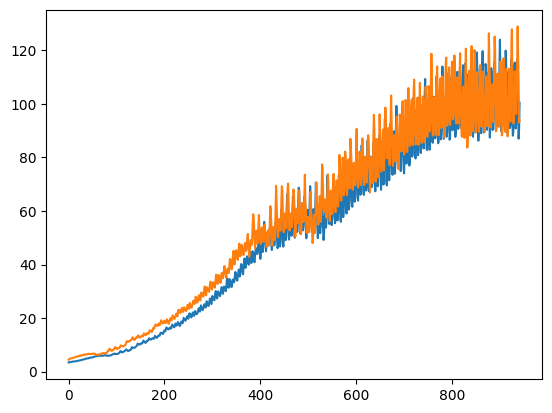

In [ ]:
from math import sqrt
from matplotlib import pyplot
# walk-forward validation on the test data
predictions = list()
raw_values_ =raw_values[:len(train_scaled)]
for i in range(len(train_scaled)):
 # make one-step forecast
 X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
 yhat = forecast_lstm(lstm_model, 1, X)
 # invert scaling
 yhat = invert_scale(scaler, X, yhat)
 # invert differencing
 yhat = inverse_difference(raw_values, yhat, len(train_scaled)+1-i)
 # store forecast
 predictions.append(yhat)
 expected = raw_values_[i]
 print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values_, predictions))
print("---------------------------------------------------------------------------------------------------------")
print('Train RMSE: %.3f' % rmse)
print("---------------------------------------------------------------------------------------------------------")

# line plot of observed vs predicted
pyplot.plot(raw_values_)
pyplot.plot(predictions)
pyplot.show()

Train RMSE: 7.331

* LSTM Forecasting and Evaluation

1/1 [==============================] - 0s 28ms/step
Month=1, Predicted=105.850931, Expected=107.758300
1/1 [==============================] - 0s 27ms/step
Month=2, Predicted=114.694665, Expected=97.081300
1/1 [==============================] - 0s 26ms/step
Month=3, Predicted=117.135366, Expected=92.302000


<ipython-input-50-2757a822ffe5>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-50-2757a822ffe5>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-50-2757a822ffe5>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 28ms/step
Month=4, Predicted=104.661106, Expected=97.721400
1/1 [==============================] - 0s 30ms/step
Month=5, Predicted=97.296676, Expected=117.237700
1/1 [==============================] - 0s 27ms/step


<ipython-input-50-2757a822ffe5>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-50-2757a822ffe5>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-50-2757a822ffe5>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=6, Predicted=107.641928, Expected=128.907100
1/1 [==============================] - 0s 31ms/step
Month=7, Predicted=110.939830, Expected=107.671100
1/1 [==============================] - 0s 31ms/step
Month=8, Predicted=124.685021, Expected=104.571600
1/1 [==============================] - 0s 29ms/step


<ipython-input-50-2757a822ffe5>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-50-2757a822ffe5>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-50-2757a822ffe5>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


Month=9, Predicted=114.419835, Expected=93.449100
1/1 [==============================] - 0s 25ms/step
Month=10, Predicted=108.321290, Expected=93.240500
1/1 [==============================] - 0s 39ms/step
Month=11, Predicted=87.093742, Expected=103.308300


<ipython-input-50-2757a822ffe5>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
<ipython-input-50-2757a822ffe5>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


1/1 [==============================] - 0s 41ms/step
Month=12, Predicted=93.107620, Expected=113.317800
---------------------------------------------------------------------------------------------------------
Test RMSE: 10.296
---------------------------------------------------------------------------------------------------------


<ipython-input-50-2757a822ffe5>:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


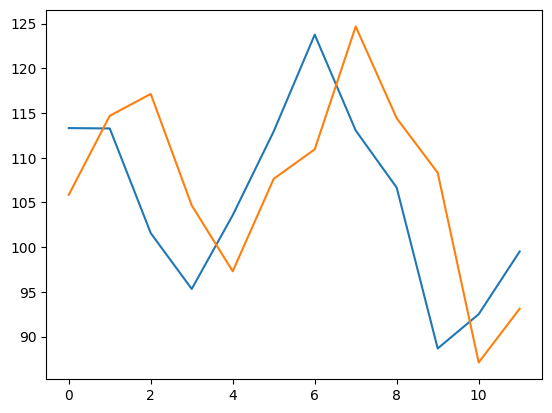

In [ ]:
from math import sqrt
from matplotlib import pyplot
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
 # make one-step forecast
 X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
 yhat = forecast_lstm(lstm_model, 1, X)
 # invert scaling
 yhat = invert_scale(scaler, X, yhat)
 # invert differencing
 yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
 # store forecast
 predictions.append(yhat)
 expected = raw_values[len(train) + i + 1]
 print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print("---------------------------------------------------------------------------------------------------------")
print('Test RMSE: %.3f' % rmse)
print("---------------------------------------------------------------------------------------------------------")

# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

Test RMSE: 10.296

## **4. Conclusion**

✍ In this notebook, we continued the work on the time series data of `energy_production`. Based on the statistical analysis that we did in the previous excercice we better carried out the experimental work. This time we modelled the time series using the Long-Short-Term-Memory `LSTM`. First, we loaded the data and set the `DATE`as date-time index for the production series. Then, we prepared the data for the LSTM model including: train-test split with 70%-30% ratio and then generating the train sets (input and output) and test sets (input and output) using the `one-to-one` strategy, differencing the dataset with one lag to transform the time-series to stationary, scaling the time series into [0,1]. For the LSTM model development, in the first three trials, we experimented with scaled-non-differenced time series  and with the following settings: `batch_size`=1, `optimizer`=`adam`, `loss`=`mean_squared_error`, `n_epochs`={100, 200, 300}, and `neurons` = {10, 5, 4}. However, in the second trial, we used scaled-differenced time series data and designed an LSTM model with the same settings as those of the first one except for the `n_epochs` this time is 300. Further, we used the trained LSTM models to predict the production for the test set, then used the `rmse` to evaluate the predicitons, here we first did inverse differencing and/or inverse scaling for the predictions to be able to calculate the difference between the real and the predicted values of the prediction.

The results of the first models are:

Trial 1: `rmse` on the train set = 35.97   and `rmse` on the test set = 69.02 ;

Trial 2: `rmse` on the train set =3.55 and `rmse` on the test set =9.79 ;

Trial 3: `rmse` on the train set =3.30 and `rmse` on the test set =8.32 ;

while the results of the fourth model are `rmse` on the train set = 7.331  and `rmse` on the test set = 10.926. We see the `rmse` of the first model on the train data is considerable and that on the test data is much higher, which indicate a potential overfitting to the data and generally the `rmse` is high indicating a low quality of the predictions and the yet a poor predictive model. The models in trial 2 and trial 3 are significantly predicting the `production` and attaining low relatively low values of `rmse`, however, the third model is attaining the  best results on the test set. The fourth model, built on stationary time series, is attaining a significantly low `rmse` compared to the first model. The `rmse` score on both train and test sets is relatively low with no considerable between them, for that the model is well fitting the data and effectively predicted the production values. We conclude that increasing the number of epochs along with minimizing the number of LSTM neurons significantly improved the results, besides the positive effect of handling the stationarity of the time series, in particular the effect of understanding the features of time series at hand and the graphical and the statistical analysis of the data in the modelling. Better insights on the data characteristics could lead to better processing and modelling yet better predictions.

**References:**

* [Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)